<a href="https://colab.research.google.com/github/JhngJng/Summer_Internship_2021/blob/main/Implementations/Node2Vec_Simple_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node2Vec Simple Implementations

### Data Science & Artificial Intelligence Lab 2021 Summer Internship

#### Jihyeong Jung, Department of Mathematical Sciences, KAIST

In [79]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/gdrive')

root = '/gdrive/My Drive/Implementations_2021 Summer Internship/GCN'

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(root)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [80]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec

### Comments
The cell below is the code for Sample Graph Generation. Generated Graph has 3 clusters, and `num_iter` parameter is propotional to the connection strength within the cluster.

In [81]:
%matplotlib inline

def GraphGeneration(num_iter=50):
  '''
  `num_iter` : if it gets bigger, the graph's connection b/w groups gets stronger
  '''
  # Graph Initialization; by some 'primitive' way and using NetworkX library
  vertices1 = np.arange(0, 30, 1) # vertices as integers
  vertices2 = np.arange(30, 60, 1)
  vertices3 = np.arange(60, 90, 1)

  # generate edges
  rng = np.random.default_rng(42) # random generator random.choice
  unnormdist = np.array([1,1,1,1,1,2,2,2,3,3, 4,6,8,10,8,6,4,4,3,3, 3,2,2,2,2,1,1,1,1,1])
  dist = unnormdist/np.sum(unnormdist)
  num_iterate = num_iter
  edges = []

  for _ in range(num_iterate):
    edge1 = rng.choice(vertices1, 2, p=dist, replace=False).tolist()
    edge2 = rng.choice(vertices2, 2, p=dist, replace=False).tolist()
    edge3 = rng.choice(vertices3, 2, p=dist, replace=False).tolist()
    edges.append(edge1)
    edges.append(edge2)
    edges.append(edge3)

  # arr = np.arange(0, 50, 1)
  # rng.shuffle(arr)
  # connect = np.concatenate((vertices.reshape(-1,1), arr.reshape(-1,1)), axis=1).tolist()

  # for edge in connect[1:25]:
  #   edges.append(edge)

  for edge in edges:
    if edge[0]==edge[1]:
      edges.remove(edge)
    for edgee in edges:
      if (edge[0]==edgee[1]) and (edge[1]==edgee[0]):
        edges.remove(edgee)

  edges.append([1, 31])
  edges.append([1, 40])
  edges.append([52, 74])
  edges.append([52, 34])
  edges.append([31, 3])

  # print(edges, len(edges))

  arr = np.array(edges)
  edges = np.unique(arr, axis=0) # edges into numpy ndarray
  # print(edges, edges.shape)

  # set classes to vertices
  c0, c1, c2 = np.zeros(30), np.ones(30), np.ones(30)*2
  label = np.concatenate((np.concatenate((c0,c1)),c2)).reshape(-1,1)

  pd_edges = pd.DataFrame(edges, columns=['Go', 'To']) # edges to pandas DataFrame
  pd_edges = pd.concat([pd_edges, pd.DataFrame({'weight' : rng.integers(low=1, high=3, size=pd_edges.shape[0]).tolist()})], axis=1)
  
  print(pd_edges)

  # Construct Graph
  my_Graph = nx.from_pandas_edgelist(pd_edges, source='Go', target='To', edge_attr=True) # Construction

  return my_Graph

### Comments
plotting the generated graph

In [82]:
# Visualize Graph
def graph_plot(my_Graph):
  plt.figure(figsize=(15,15))
  nx.draw_networkx(G=my_Graph, node_color='blue', width=1.0, edge_color='skyblue', font_color='white')
  plt.show()

### Comments
Node2Vec Algorithm; based on biased random walk controlled by 2 hyperparameters, `p` and `q`

In [83]:
#### Node2Vec Algorithm ####
## In here, I just modified my implementations of DeepWalk, especially on 'biased walk'

def Node2Vec(G=None, w=10, d=3, gamma=30, t=40, p=1, q=1):
  '''
  <Input>
  Graph G (class networkx.Graph)

  <Hyperparameters>
  Window size w (int)
  Imbedding dimension d (int)
  Walks per vertex gamma (int)
  Walk length t (int)
  Return parameter p (float)
  In-Out parameter q (float)


  <Output>
  Imbedding X_embed (class numpy.ndarray)
  '''

  ############ defining function of making Biased Random Walks #################
  def BiasedRandWalk(G, N, t, p, q):
    '''
    <Input>
    Graph G (class networkx.Graph)
    root node N
    Walk length t (int)
    Return parameter p (float)
    In-Out parameter q (float)

    <Output>
    Walk walk (python list)
    '''
    rng = np.random.default_rng(42)

    walk = [str(N)] # defining walk
    prev = None # previous state
    curr = N # current state
    next = None # next state

    # Sampling the nodes t-1 times
    for i in range(t-1):
      nbhd =  list(G.neighbors(curr)) # get list of neighbors of the current node
      # if given current node is isolated, break the loop.
      if len(nbhd) < 0:
        break

      # at first sample draw
      if i==0:
        unnormdist = np.array([d["weight"] for (u, v, d) in G.edges(curr, data=True, default=1)])
        nbhd = [v for (u, v, d) in G.edges(curr, data=True, default=1)]
        normdist = unnormdist/np.sum(unnormdist)
        prev = curr # updating previous state
        next = rng.choice(nbhd, p=normdist) # updating next state
        curr = next # updating current state

      else:
        unnormdist = []
        nbhd = []
        for (u, v, d) in G.edges(curr, data=True, default=1):
          nbhd.append(v)
          if v in list(G.neighbors(prev)):
            trans_prob = d['weight']
          elif prev == v:
            trans_prob = d['weight']/p
          else:
            trans_prob = d['weight']/q
          unnormdist.append(trans_prob)
        unnormdist = np.array(unnormdist)
        normdist = unnormdist/np.sum(unnormdist)
        prev = curr # updating previous state
        next = rng.choice(nbhd, p=normdist) # updating next state
        curr = next # updating current state

      # recording
      walk.append(str(next))

    return walk
  ######################################################################
  rng = np.random.default_rng(42)
  NodeList = list(G.nodes())

  # Random Walk generating process
  walks = []
  for i in range(gamma):
    for node in NodeList:
      walk = BiasedRandWalk(G, node, t, p, q)
      walks.append(walk)
    rng.shuffle(NodeList) # shuffle the nodes

  # updating representation
  model = Word2Vec(sentences=walks, size=d, window=w, min_count=0, sg=1, iter=100, batch_words=1, workers=4)

  return model.wv.vectors, model

### Comments
The function defined below shows lots of results;
1. It shows the 3-dimensional scatter plot of learned representations, by blue dots
2. It also shows the plot of one cluster by red dots ,we can check homophily at here
3. It also shows the 'Central nodes' of clusters of the graph; we can check the structural role similarity.
4. Finally, it also prints the top 10 nodes that has similar representations
 to 'central nodes', we also can check homophily and structural role similarity.

In [84]:
def representation_create_and_plot(my_Graph, p, q):
  import time
  ## creating representations of my_Graphs.
  t = time.time()
  ver_rep, model = Node2Vec(G=my_Graph, d=3, p=p, q=q)
  print("Elapsed time: {:.4f}s".format(time.time()-t))

  # plot the results
  fig = plt.figure(figsize=(32,18))
  ax = fig.gca(projection='3d')
  x, y, z = ver_rep[:,0], ver_rep[:,1], ver_rep[:,2]
  ax.scatter(x,y,z, s=150, c='black')

  # checking homophily
  for i in range(30):
    node1, node2, node3 = i, i+30, i+60 # nodes in different clusters
    if node1 in list(my_Graph.nodes()):
      vec1 = model.wv[str(node1)]
      x1, y1, z1 = vec1[0], vec1[1], vec1[2]
      ax.scatter(x1,y1,z1, s=500, c='red')
    if node2 in list(my_Graph.nodes()):
      vec2 = model.wv[str(node2)]
      x2, y2, z2 = vec2[0], vec2[1], vec2[2]
      ax.scatter(x2,y2,z2, s=500, c='yellow')
    if node3 in list(my_Graph.nodes()):
      vec3 = model.wv[str(node3)]
      x3, y3, z3 = vec3[0], vec3[1], vec3[2]
      ax.scatter(x3,y3,z3, s=500, c='orange')

  # checking Structural equivalence
  for i in [12, 13, 14, 42, 43, 44, 72, 73, 74]:
    if i in list(my_Graph.nodes()):
      vec = model.wv[str(i)]
      x, y, z = vec[0], vec[1], vec[2]
      ax.scatter(x,y,z, s=500, c='blue')
  
  # Also checking Homophily and Structural Equivalence by looking at similar vectors obtained by cosine similarity
  for i in [12, 13, 14, 42, 43, 44, 72, 73, 74]:
    if i in list(my_Graph.nodes()):
      print("Nodes that has similar representaion to 'Central Node {}'".format(i))
      print(model.wv.most_similar(str(i)))

  plt.title('representations for the graph <my_Graph>'.format, fontsize=24)
  plt.show()
  

### Comments

Experiments are done for various settings of the hyperparameters `p` and `q`.

Here, experiments are done for the sample graph that has 'strong' connections in clusters.


     Go  To  weight
0     0   9       1
1     1   9       1
2     1  19       2
3     1  31       2
4     1  40       2
..   ..  ..     ...
315  87  88       1
316  88  73       1
317  88  77       2
318  89  74       2
319  89  76       1

[320 rows x 3 columns]


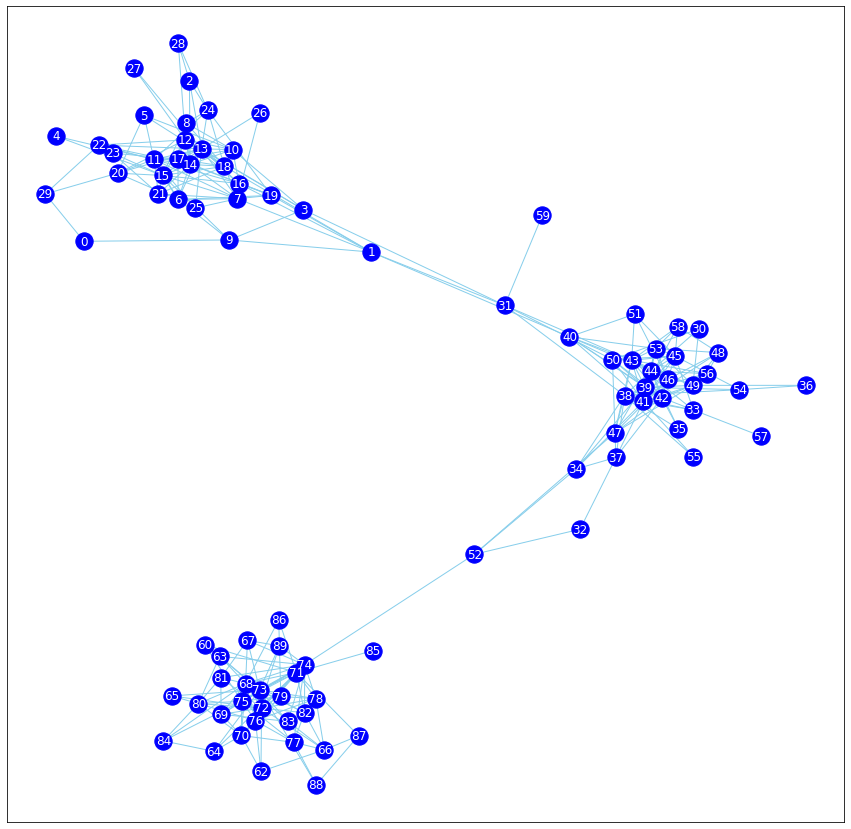

Elapsed time: 72.4746s
Nodes that has similar representaion to 'Central Node 12'
[('7', 0.9999645948410034), ('18', 0.9998003840446472), ('14', 0.9997963905334473), ('1', 0.9996331930160522), ('10', 0.9989847540855408), ('17', 0.9989664554595947), ('20', 0.9988776445388794), ('11', 0.9986916780471802), ('25', 0.9983570575714111), ('6', 0.9976345300674438)]
Nodes that has similar representaion to 'Central Node 13'
[('16', 0.9986593127250671), ('24', 0.9964728951454163), ('28', 0.995069146156311), ('15', 0.9949368834495544), ('23', 0.9931614995002747), ('4', 0.9921320676803589), ('27', 0.9912570118904114), ('26', 0.9904324412345886), ('21', 0.9899976253509521), ('5', 0.9841986298561096)]
Nodes that has similar representaion to 'Central Node 14'
[('18', 0.9999856948852539), ('12', 0.999796450138092), ('7', 0.9996489882469177), ('17', 0.9995670318603516), ('10', 0.9995589256286621), ('11', 0.9994512796401978), ('1', 0.9992234706878662), ('6', 0.9987202882766724), ('5', 0.9986345171928406),

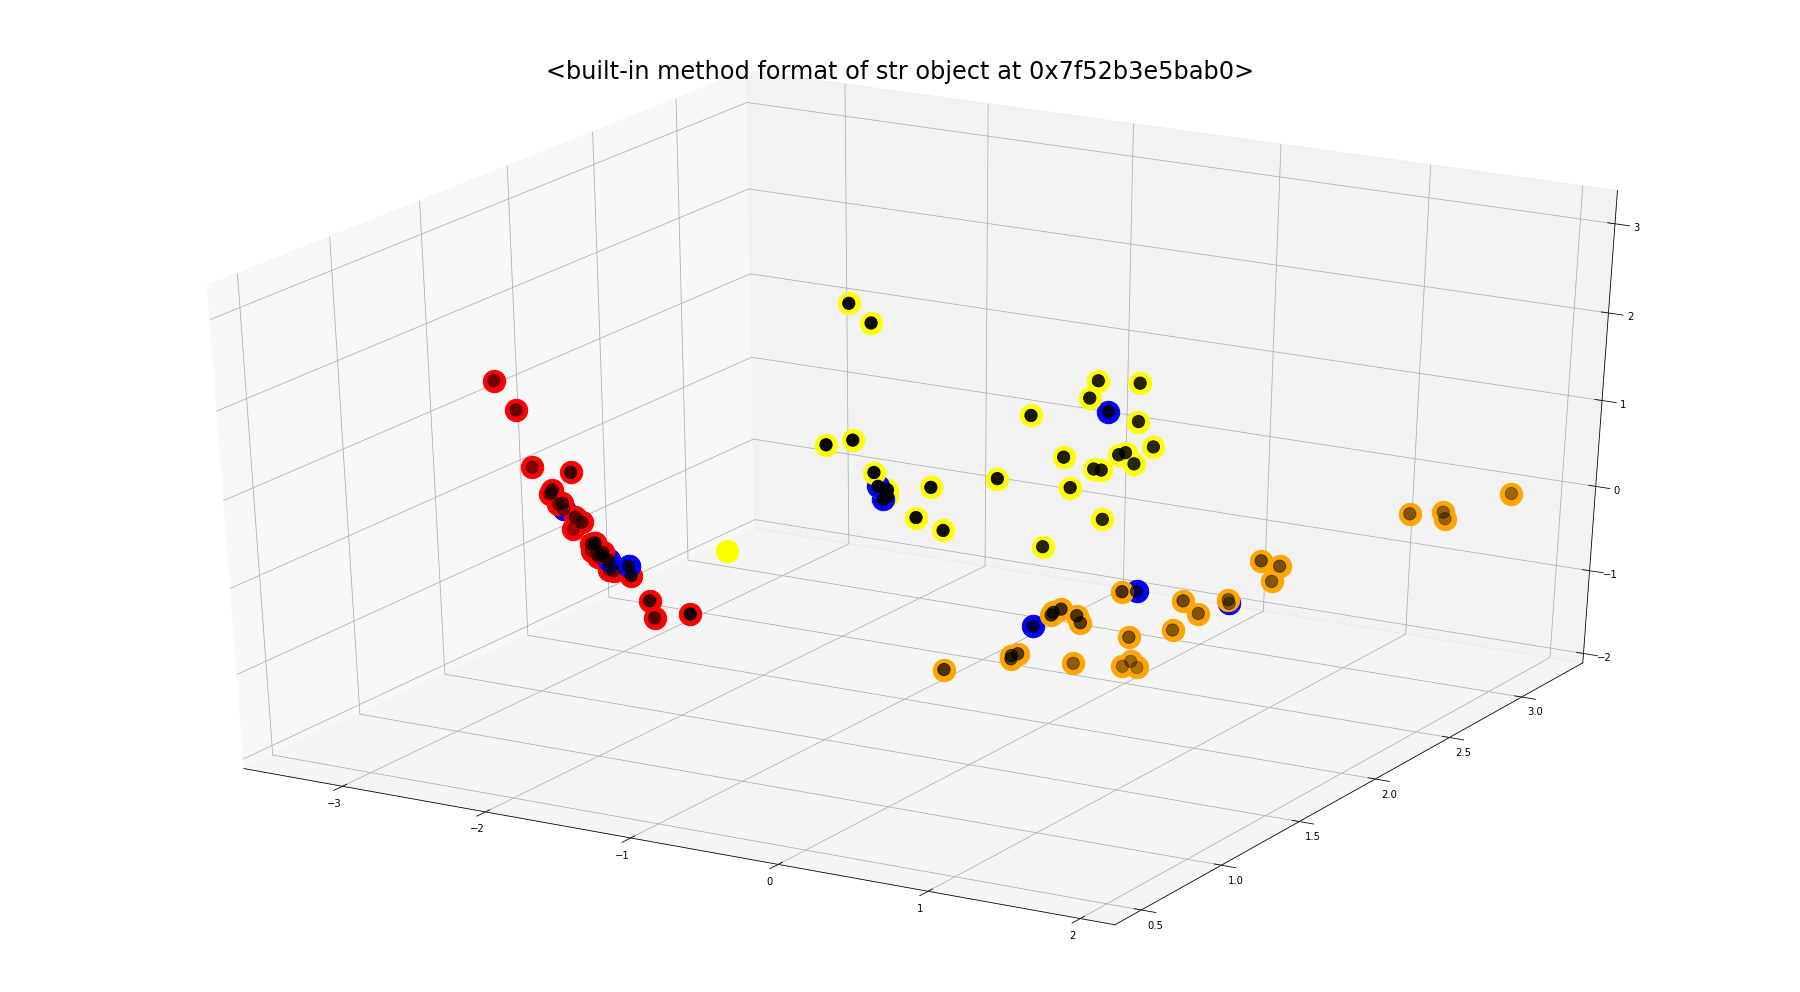

In [85]:
# Experiment on the strong group connection graph; by changing the hyperparameter p, q
graph150 = GraphGeneration(150)
graph_plot(graph150)
representation_create_and_plot(graph150, p=1, q=0.25) # with setting p=1, q=0.25

Elapsed time: 71.5129s
Nodes that has similar representaion to 'Central Node 12'
[('11', 0.9999310374259949), ('13', 0.9994524717330933), ('27', 0.9987249970436096), ('10', 0.9986841082572937), ('6', 0.9967856407165527), ('7', 0.9933232665061951), ('16', 0.991774320602417), ('17', 0.991338312625885), ('21', 0.9811632037162781), ('14', 0.9776840209960938)]
Nodes that has similar representaion to 'Central Node 13'
[('10', 0.9998254776000977), ('11', 0.99977046251297), ('12', 0.9994524717330933), ('7', 0.9965596795082092), ('27', 0.9965137243270874), ('17', 0.995140790939331), ('6', 0.9935899972915649), ('16', 0.9904382228851318), ('21', 0.9870176315307617), ('14', 0.9840993285179138)]
Nodes that has similar representaion to 'Central Node 14'
[('5', 0.9999616742134094), ('21', 0.9998497366905212), ('8', 0.9997960925102234), ('18', 0.9997273683547974), ('24', 0.9987611174583435), ('17', 0.9968034029006958), ('4', 0.9957601428031921), ('7', 0.9951858520507812), ('22', 0.9944276809692383), (

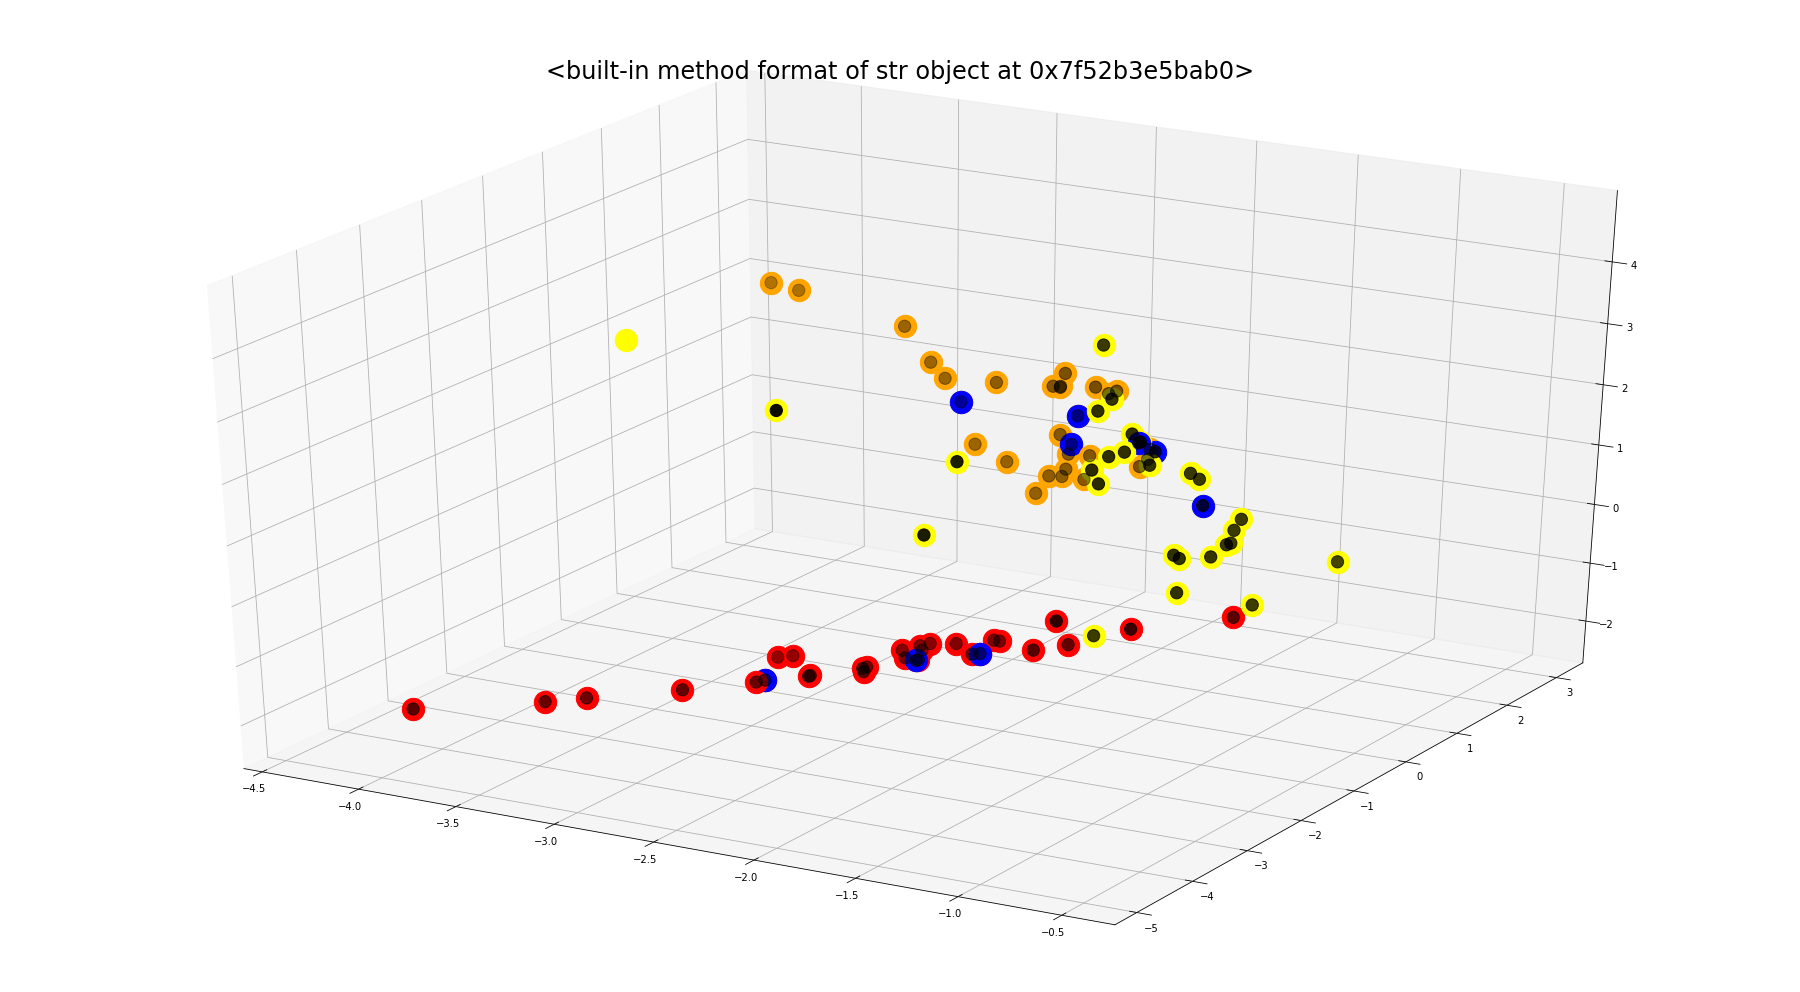

In [86]:
# Experiment on the strong group connection graph; by changing the hyperparameter p, q
representation_create_and_plot(graph150, p=1, q=4) # with setting p=1, q=4

Elapsed time: 71.7988s
Nodes that has similar representaion to 'Central Node 12'
[('11', 0.9999414682388306), ('9', 0.9998916983604431), ('14', 0.9996787905693054), ('15', 0.9986615180969238), ('10', 0.9983856678009033), ('20', 0.9981358647346497), ('19', 0.9981350302696228), ('6', 0.9970632195472717), ('21', 0.9957886338233948), ('16', 0.9946146011352539)]
Nodes that has similar representaion to 'Central Node 13'
[('18', 0.9991844296455383), ('27', 0.999143123626709), ('7', 0.9982392191886902), ('24', 0.9979289174079895), ('8', 0.9967727065086365), ('16', 0.9928946495056152), ('17', 0.990494430065155), ('6', 0.9892668724060059), ('28', 0.9876663088798523), ('20', 0.9865837097167969)]
Nodes that has similar representaion to 'Central Node 14'
[('12', 0.9996787905693054), ('11', 0.9993476867675781), ('9', 0.9992194771766663), ('21', 0.9977806806564331), ('19', 0.9977321028709412), ('10', 0.9975453615188599), ('15', 0.9972235560417175), ('20', 0.9963566660881042), ('6', 0.9950087070465088

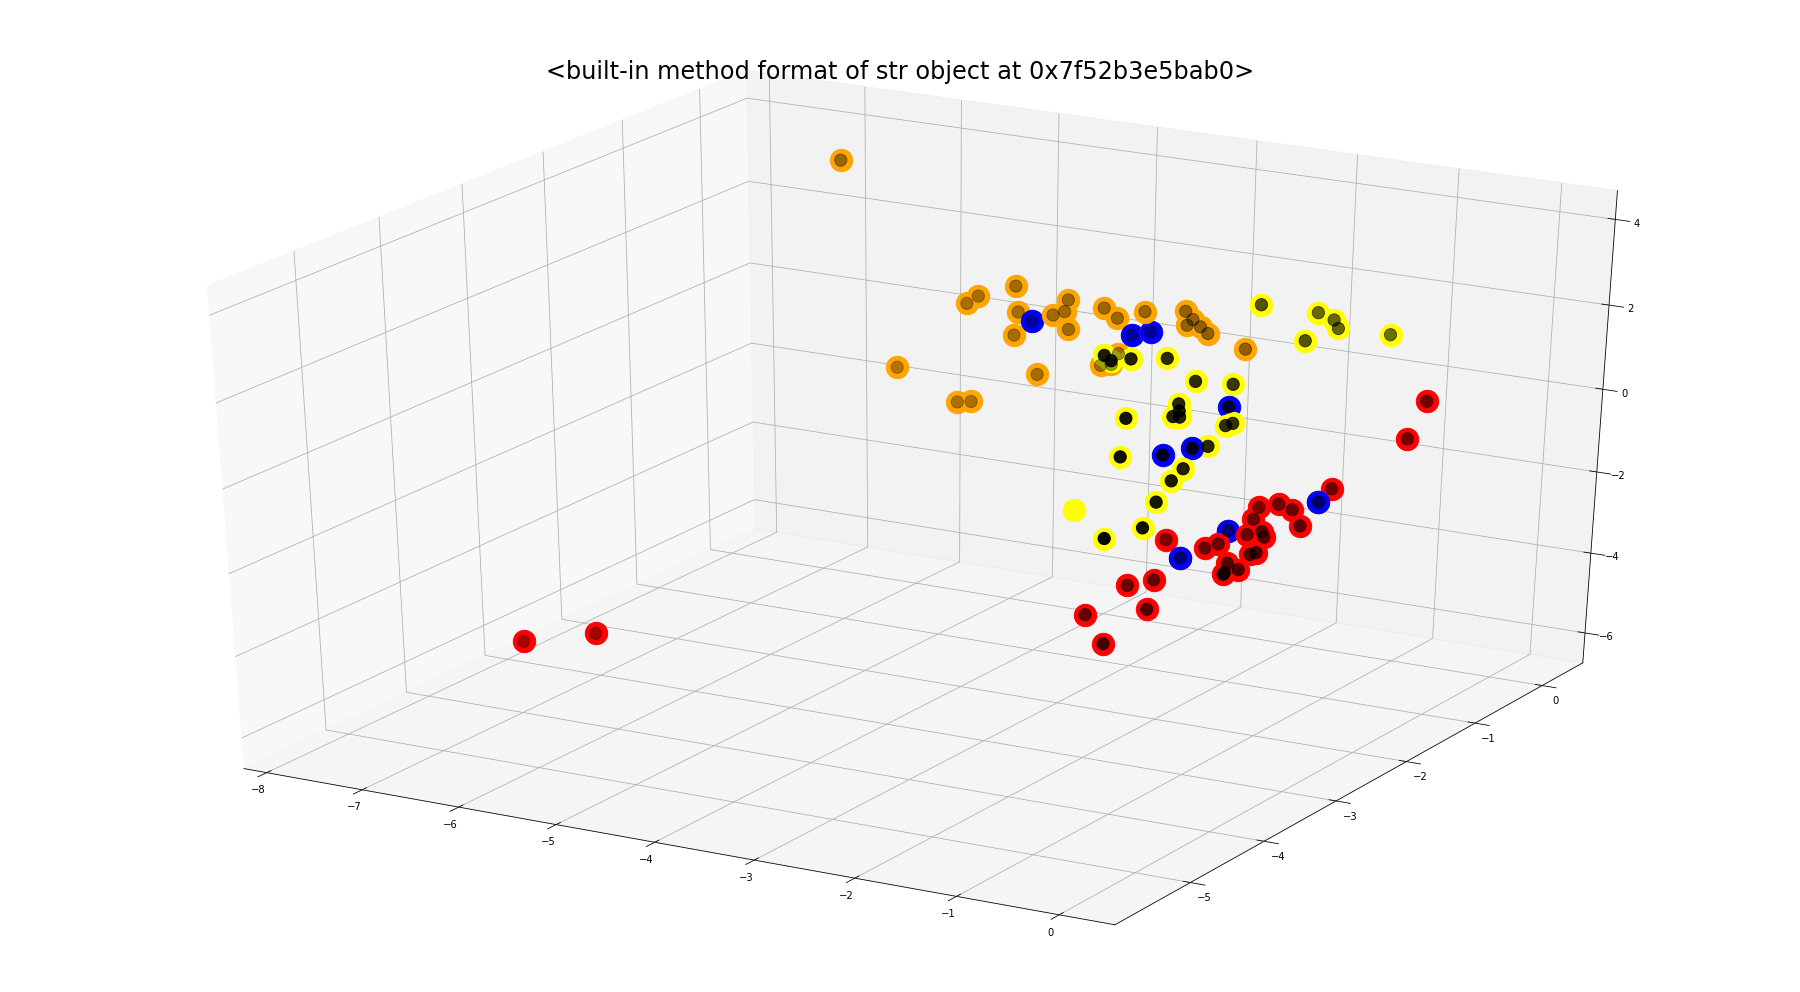

In [87]:
# to check the effect of the hyperparameters; same setting with above except p decreased(p = 1 -> p = 0.25)
representation_create_and_plot(graph150, p=0.25, q=4) # with setting p=0.25, q=4

Elapsed time: 70.5530s
Nodes that has similar representaion to 'Central Node 12'
[('18', 0.9999194145202637), ('10', 0.9993458390235901), ('5', 0.9988251328468323), ('16', 0.9963629841804504), ('27', 0.9955116510391235), ('8', 0.992942750453949), ('14', 0.992693305015564), ('7', 0.9924329519271851), ('21', 0.9907054305076599), ('13', 0.9893103241920471)]
Nodes that has similar representaion to 'Central Node 13'
[('25', 0.9999800324440002), ('7', 0.99972003698349), ('11', 0.999534010887146), ('27', 0.998668909072876), ('21', 0.9986135959625244), ('16', 0.9981380105018616), ('3', 0.9981220960617065), ('26', 0.9964248538017273), ('22', 0.994757354259491), ('12', 0.9893102645874023)]
Nodes that has similar representaion to 'Central Node 14'
[('8', 0.9999525547027588), ('20', 0.9995935559272766), ('6', 0.9985018372535706), ('15', 0.998371958732605), ('5', 0.9972918629646301), ('17', 0.996694803237915), ('10', 0.9963803887367249), ('18', 0.9941449165344238), ('12', 0.992693305015564), ('4', 

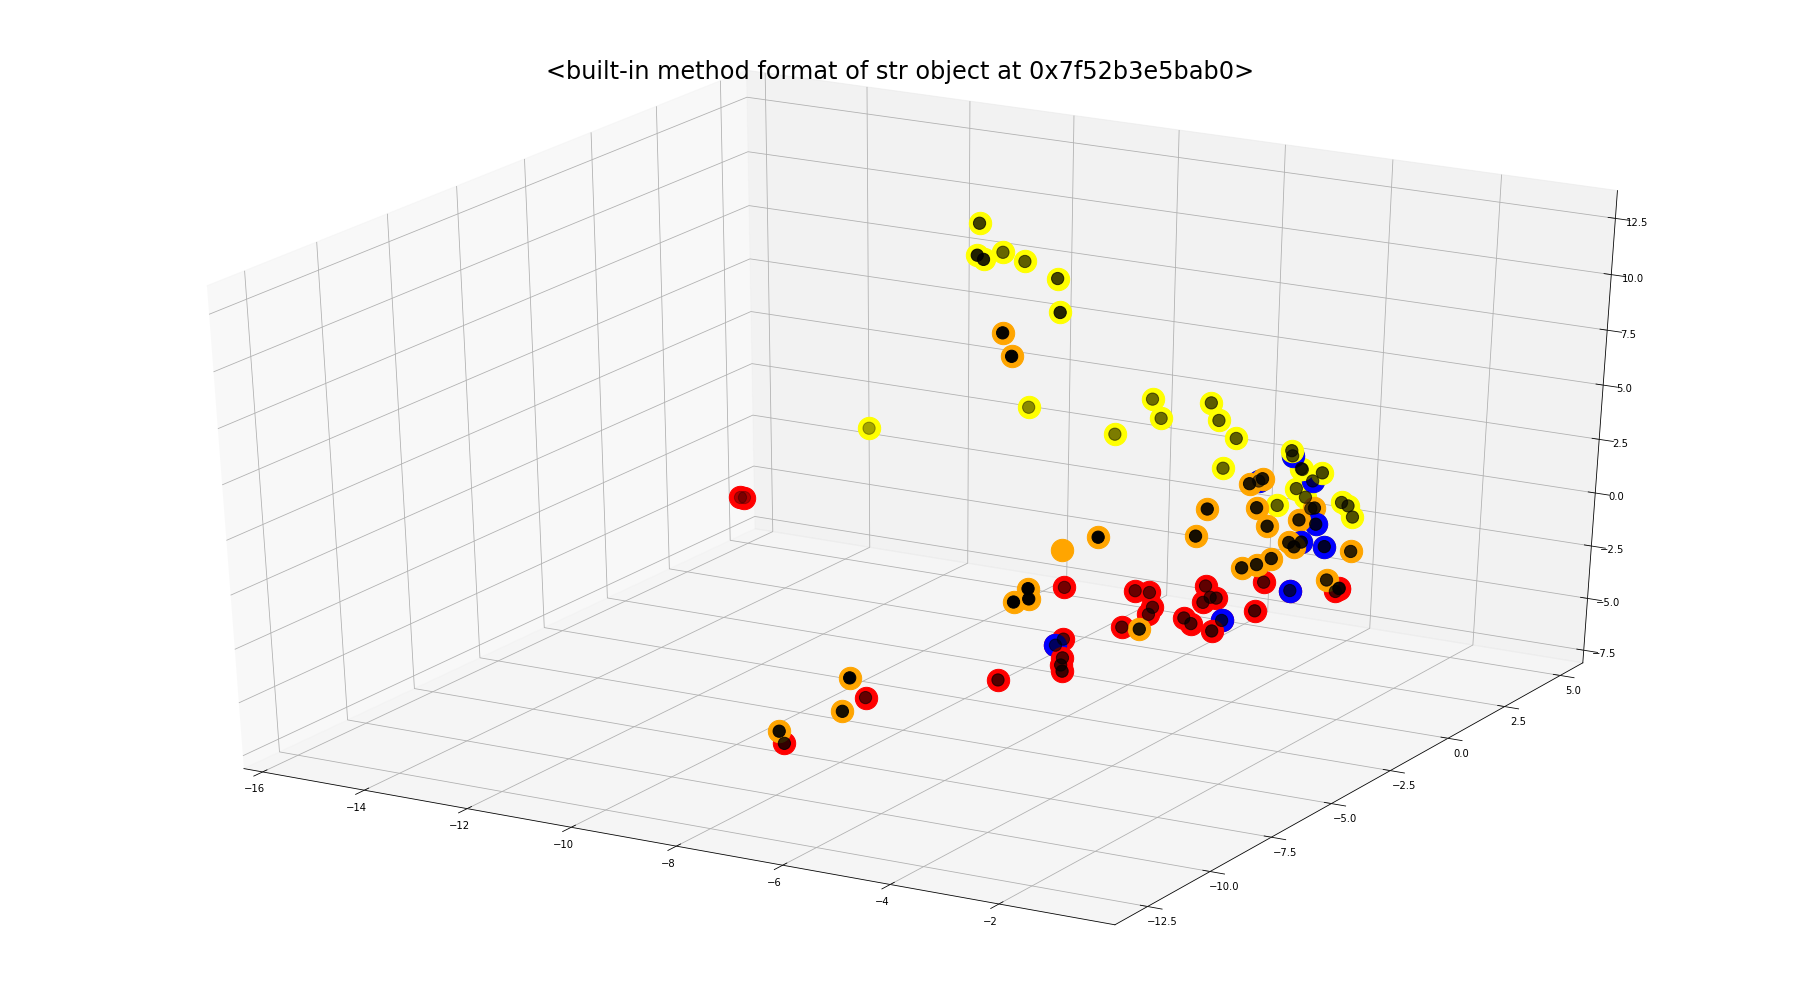

In [88]:
# to check the effect of the hyperparameters; same setting with above except p decreased, q increased (p=0.25 -> p=0.05, q=4->q=20)
representation_create_and_plot(graph150, p=0.05, q=20) # with setting p=0.05, q=20

Elapsed time: 71.7352s
Nodes that has similar representaion to 'Central Node 12'
[('27', 0.9998127818107605), ('17', 0.9992357492446899), ('10', 0.9992268681526184), ('1', 0.999216616153717), ('15', 0.9991147518157959), ('28', 0.9990902543067932), ('18', 0.9988420009613037), ('6', 0.998722493648529), ('13', 0.9949902296066284), ('9', 0.9949573278427124)]
Nodes that has similar representaion to 'Central Node 13'
[('9', 0.9999546408653259), ('6', 0.9987543821334839), ('11', 0.9986322522163391), ('28', 0.9983391761779785), ('1', 0.9981326460838318), ('24', 0.9980500340461731), ('14', 0.9958908557891846), ('12', 0.994990348815918), ('27', 0.992885172367096), ('3', 0.9917653203010559)]
Nodes that has similar representaion to 'Central Node 14'
[('24', 0.9995813965797424), ('3', 0.9992709755897522), ('11', 0.9992358684539795), ('22', 0.9989009499549866), ('9', 0.9959045648574829), ('13', 0.9958907961845398), ('4', 0.993882417678833), ('8', 0.9930126667022705), ('6', 0.9901912212371826), ('28'

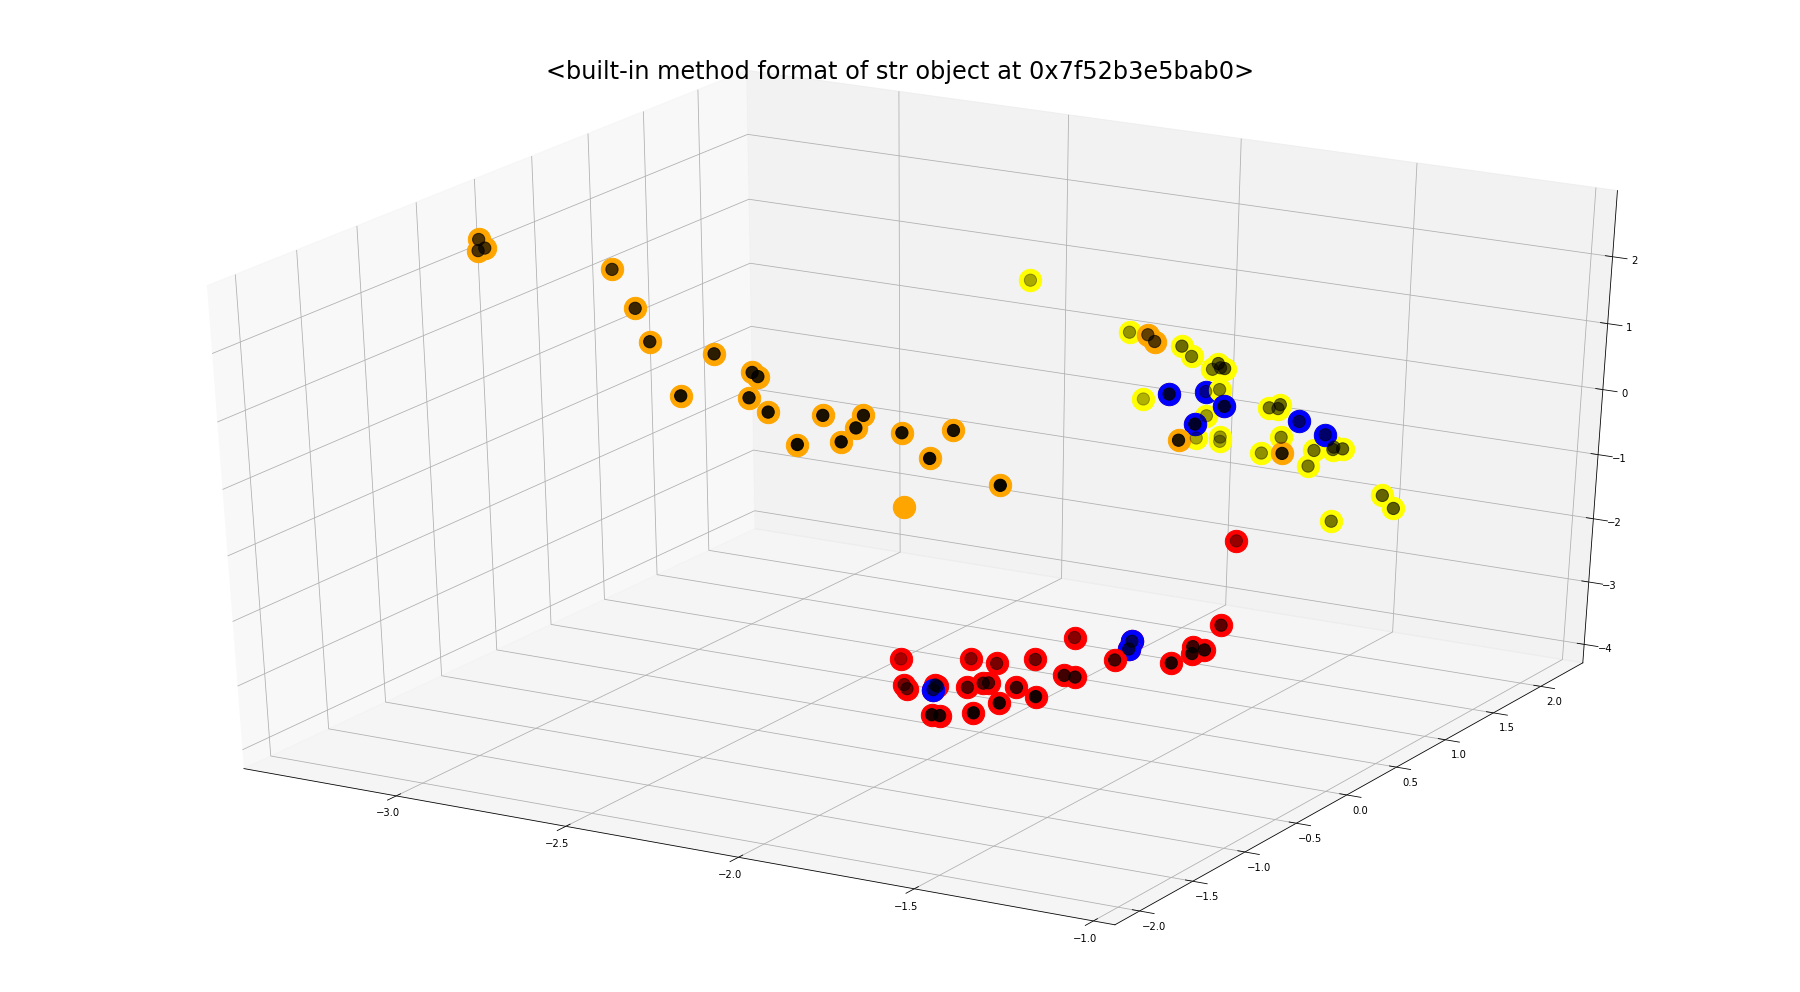

In [89]:
# to check the effect of the hyperparameters; same setting with above except p increased, q decreased (p=0.05 -> p=4, q=20->q=1)
representation_create_and_plot(graph150, p=4, q=1) # with setting p=4, q=1

Elapsed time: 71.2136s
Nodes that has similar representaion to 'Central Node 12'
[('9', 0.9992693662643433), ('24', 0.9990967512130737), ('8', 0.9986497759819031), ('13', 0.9981129765510559), ('16', 0.9970564246177673), ('0', 0.9968885779380798), ('6', 0.9959608912467957), ('3', 0.9956459403038025), ('10', 0.9942016005516052), ('22', 0.9936488270759583)]
Nodes that has similar representaion to 'Central Node 13'
[('8', 0.999952495098114), ('16', 0.9997326135635376), ('24', 0.9997221827507019), ('0', 0.9996389746665955), ('9', 0.9995283484458923), ('6', 0.9994022846221924), ('10', 0.9988386631011963), ('22', 0.9985458850860596), ('17', 0.9985318183898926), ('12', 0.9981129765510559)]
Nodes that has similar representaion to 'Central Node 14'
[('7', 0.9997603893280029), ('29', 0.9996157884597778), ('17', 0.9994295239448547), ('22', 0.9993967413902283), ('10', 0.9992166757583618), ('20', 0.9989228844642639), ('28', 0.998831033706665), ('6', 0.9982954859733582), ('0', 0.9975737929344177), ('

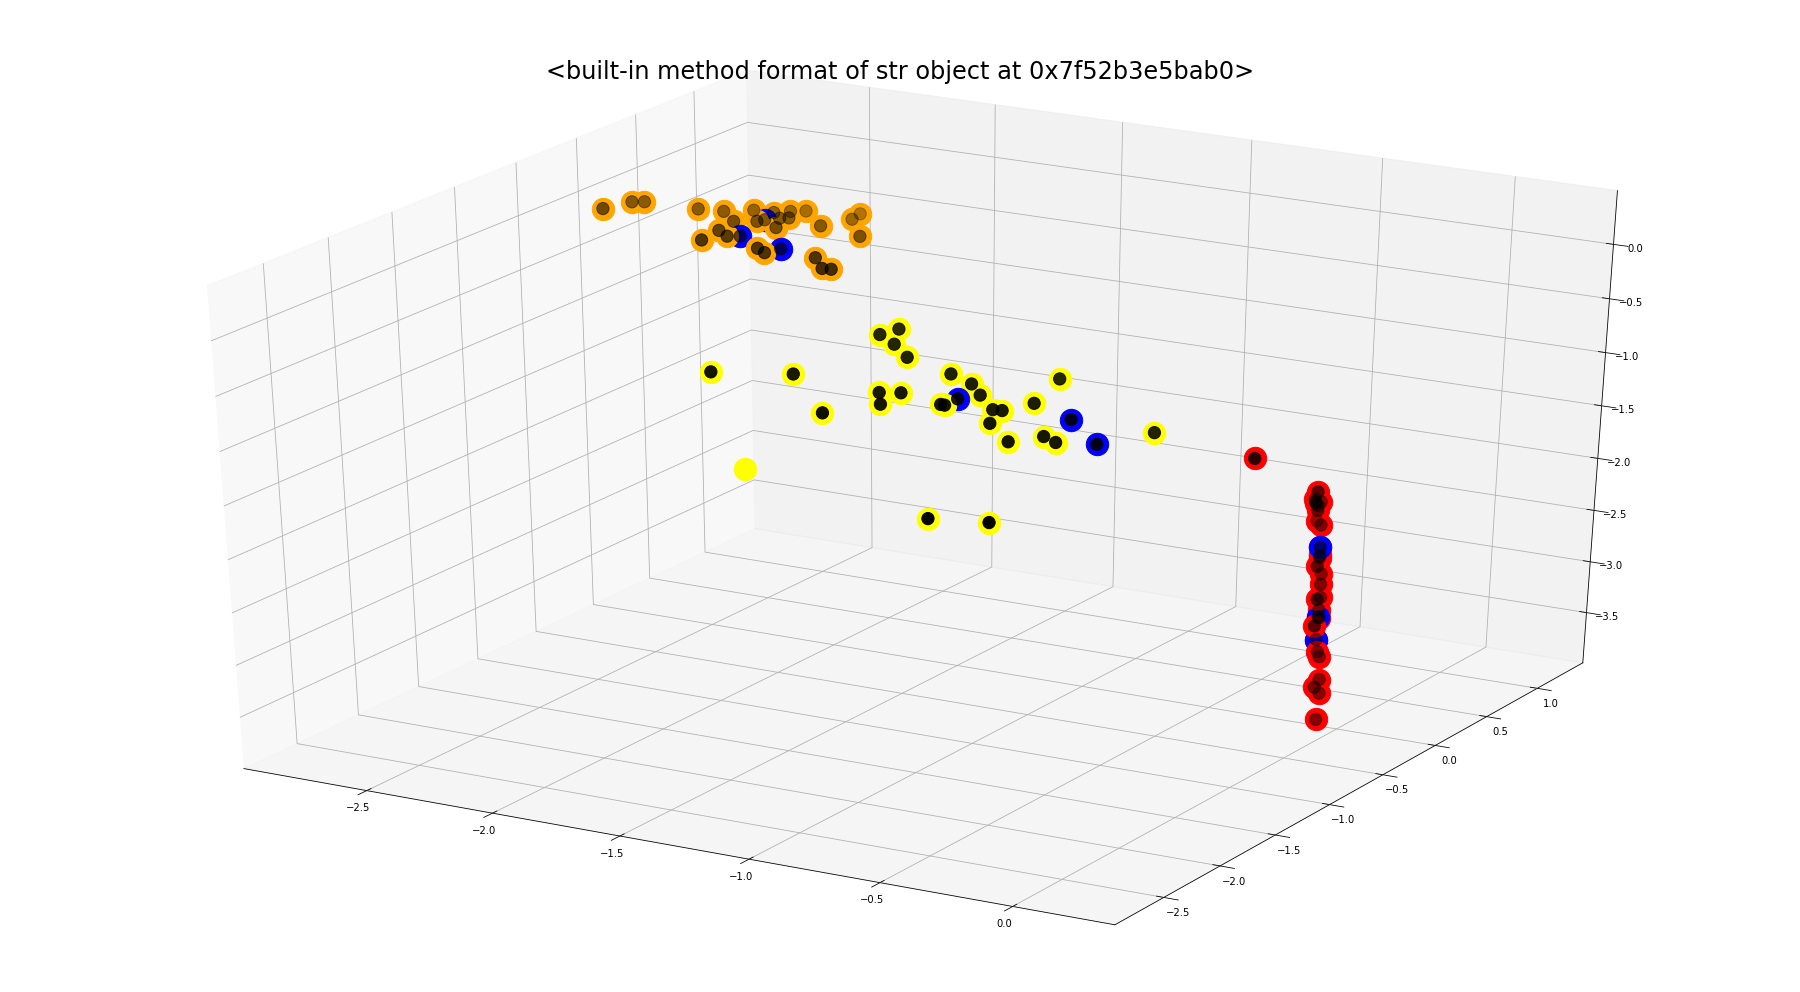

In [90]:
# to check the effect of the hyperparameters; same setting with above except q decreased (q=1->q=0.25)
representation_create_and_plot(graph150, p=4, q=0.25) # with setting p=4, q=0.25

Elapsed time: 71.5292s
Nodes that has similar representaion to 'Central Node 12'
[('11', 0.9999971985816956), ('17', 0.9999751448631287), ('22', 0.999934196472168), ('9', 0.9997888803482056), ('29', 0.9996330738067627), ('28', 0.9994276165962219), ('10', 0.9992880821228027), ('8', 0.9989269971847534), ('24', 0.9986081719398499), ('0', 0.9979674220085144)]
Nodes that has similar representaion to 'Central Node 13'
[('16', 0.9998383522033691), ('18', 0.9998060464859009), ('14', 0.9997804760932922), ('23', 0.9996665120124817), ('19', 0.9992215633392334), ('3', 0.9991602301597595), ('2', 0.9990502595901489), ('21', 0.9977631568908691), ('0', 0.9943002462387085), ('24', 0.9926401972770691)]
Nodes that has similar representaion to 'Central Node 14'
[('18', 0.999934196472168), ('13', 0.9997805953025818), ('16', 0.9992948174476624), ('23', 0.998918890953064), ('21', 0.9986944794654846), ('19', 0.9986279010772705), ('2', 0.9985196590423584), ('3', 0.9981379508972168), ('0', 0.9921453595161438), 

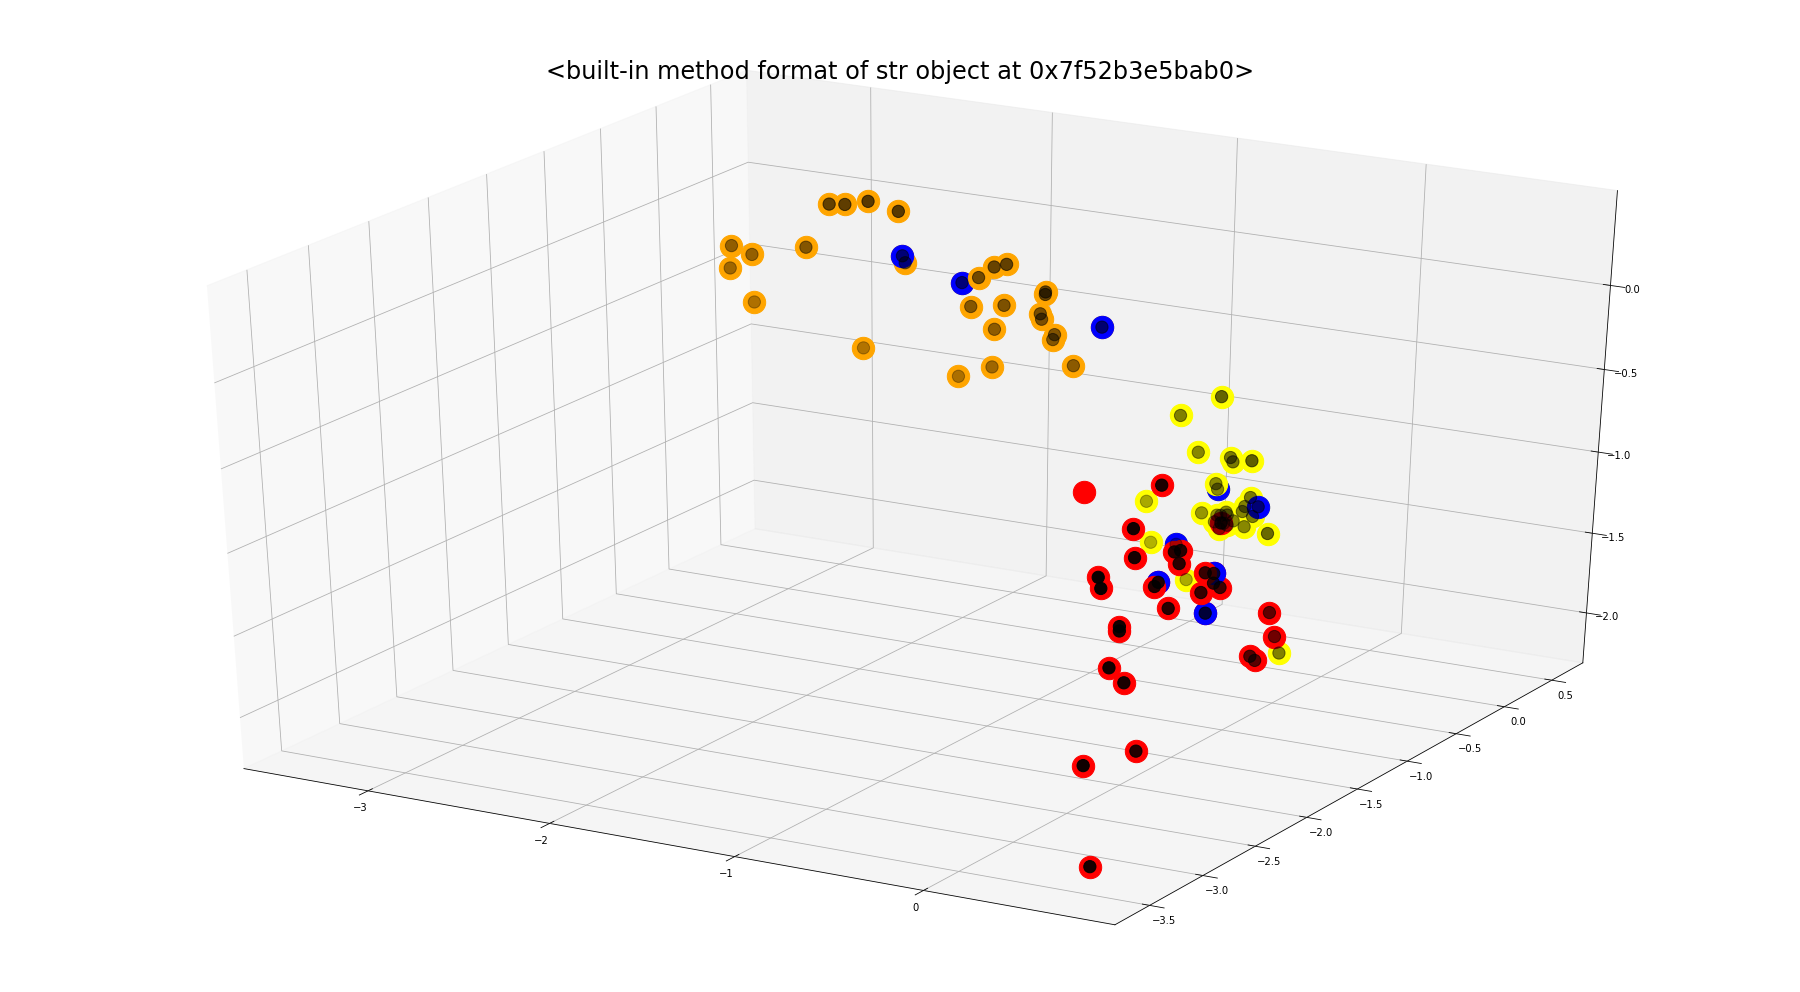

In [91]:
# to check the effect of the hyperparameters; same setting with above except p increased, q decreased (p=4 -> p=20, q=0.25->q=0.05)
representation_create_and_plot(graph150, p=20, q=0.05) # with setting p=20, q=0.05

# comments
Here, experiments are done for the sample graph that has 'weaker' connections in clusters.

     Go  To  weight
0     1  31       1
1     1  40       2
2     2  13       2
3     3   9       2
4     4  15       1
..   ..  ..     ...
187  84  75       1
188  85  71       1
189  86  71       2
190  88  77       2
191  89  76       1

[192 rows x 3 columns]


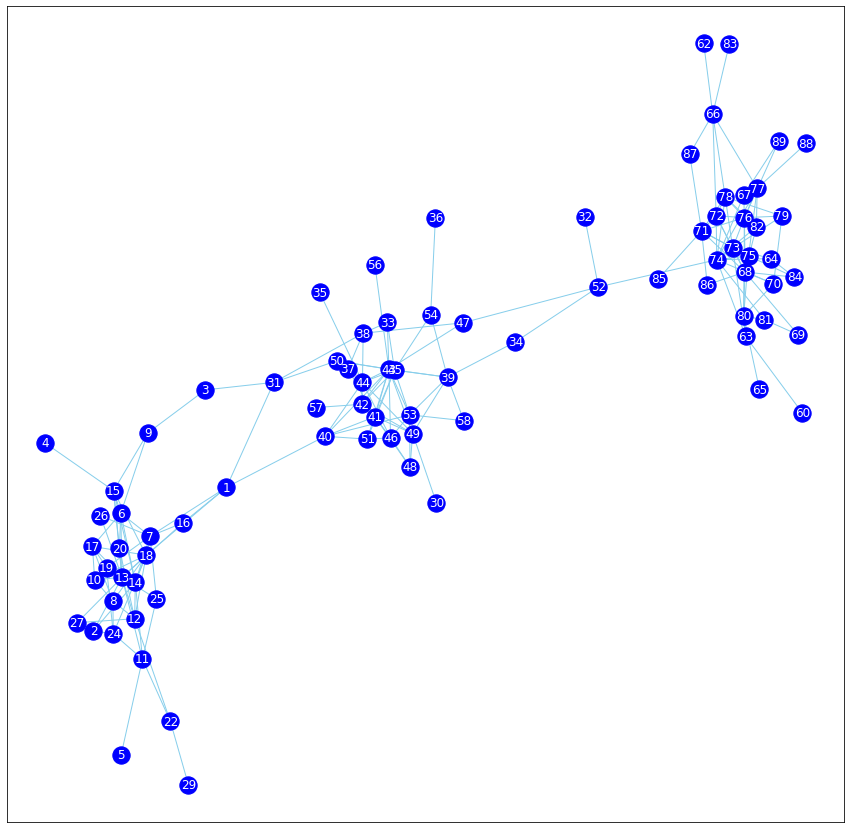

In [92]:
### Experiment on the graph that has 'Weeker connection in cluster'
graph75 = GraphGeneration(75)
graph_plot(graph75)

Elapsed time: 65.3413s
Nodes that has similar representaion to 'Central Node 12'
[('16', 0.999933660030365), ('27', 0.9995728731155396), ('6', 0.9993805289268494), ('17', 0.9988844394683838), ('26', 0.9984372854232788), ('8', 0.9981619119644165), ('7', 0.9979887008666992), ('10', 0.9973388314247131), ('13', 0.9971384406089783), ('14', 0.9884282946586609)]
Nodes that has similar representaion to 'Central Node 13'
[('7', 0.9999170303344727), ('8', 0.9998628497123718), ('26', 0.9998041391372681), ('17', 0.9995959401130676), ('6', 0.9991810321807861), ('12', 0.9971384406089783), ('14', 0.9970638751983643), ('20', 0.9964871406555176), ('16', 0.9963095188140869), ('27', 0.9945433139801025)]
Nodes that has similar representaion to 'Central Node 14'
[('20', 0.999973714351654), ('15', 0.99958336353302), ('11', 0.997611939907074), ('13', 0.9970638751983643), ('24', 0.9966959953308105), ('7', 0.9960238933563232), ('1', 0.9959821105003357), ('8', 0.9957307577133179), ('26', 0.9953603148460388), ('

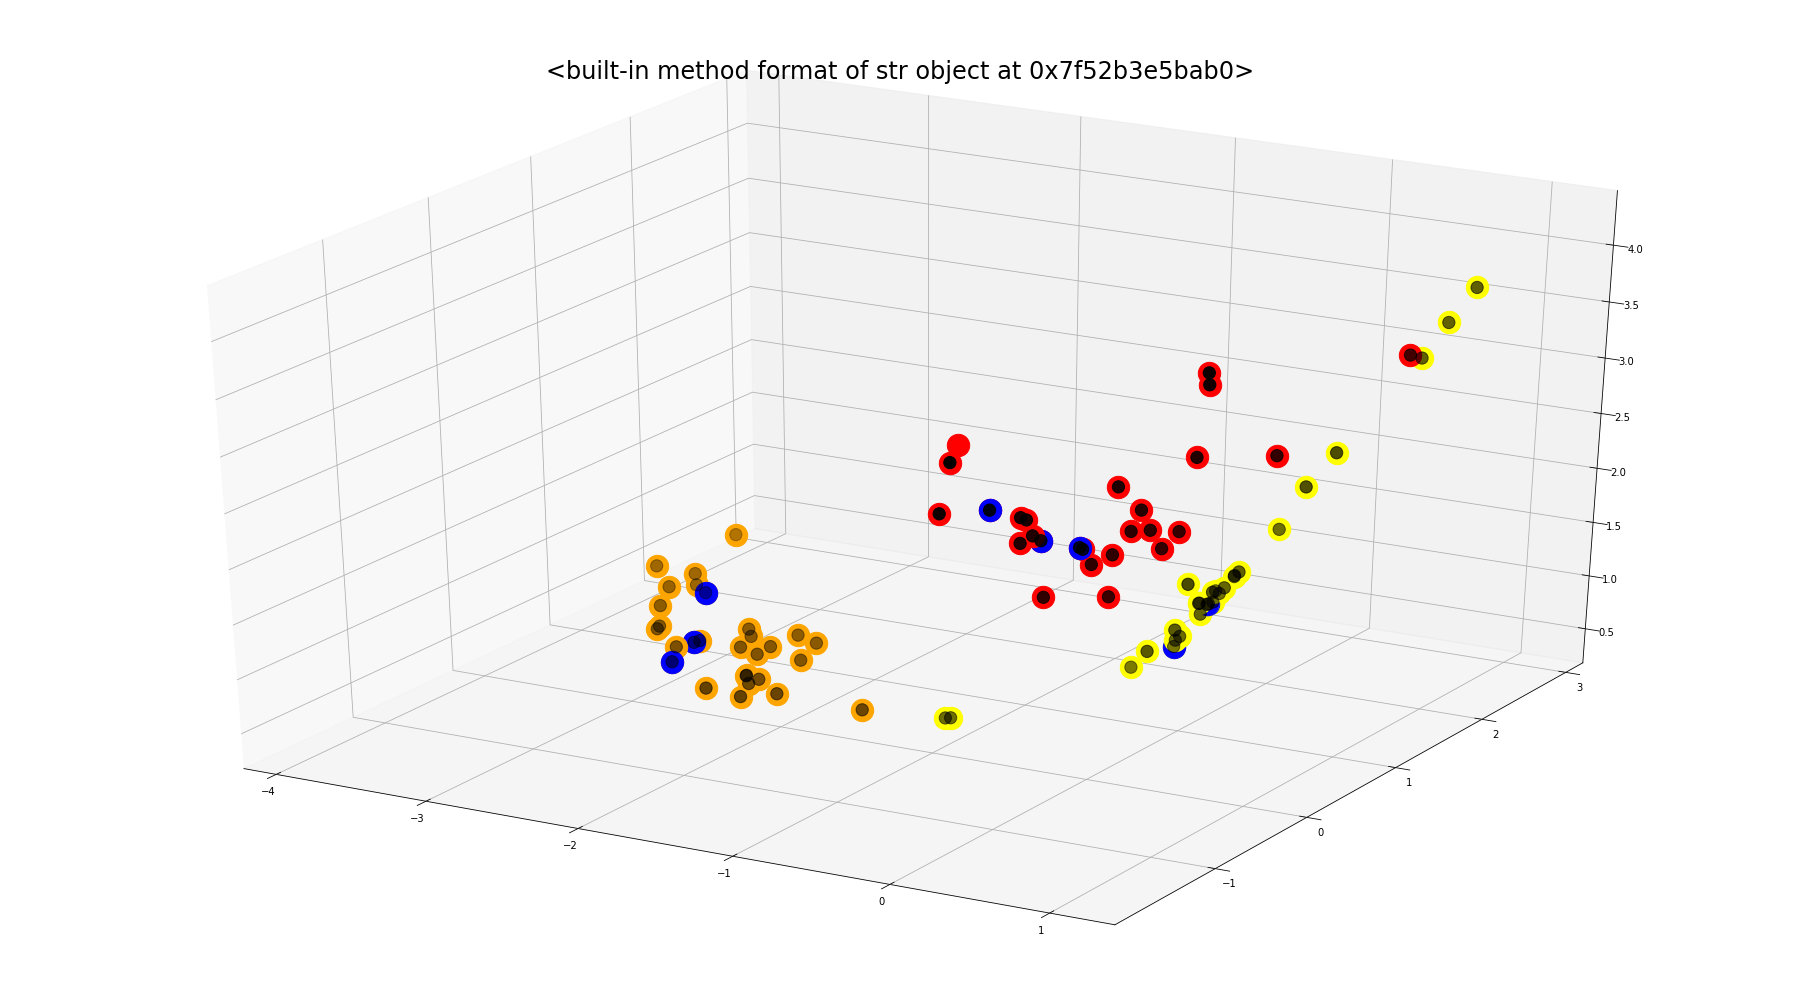

In [93]:
representation_create_and_plot(graph75, p=1, q=0.25) # with setting p=1, q=0.25

Elapsed time: 65.7561s
Nodes that has similar representaion to 'Central Node 12'
[('27', 0.9999937415122986), ('14', 0.9999876022338867), ('19', 0.9999867677688599), ('26', 0.9998176097869873), ('17', 0.9996145367622375), ('13', 0.9996142983436584), ('20', 0.999500572681427), ('6', 0.9994266629219055), ('15', 0.9982680678367615), ('11', 0.9965335130691528)]
Nodes that has similar representaion to 'Central Node 13'
[('20', 0.9999842047691345), ('14', 0.999681830406189), ('12', 0.9996142983436584), ('19', 0.9995406866073608), ('27', 0.9995105266571045), ('26', 0.9991258382797241), ('17', 0.9984810948371887), ('6', 0.9981091618537903), ('25', 0.9980762600898743), ('15', 0.9962583184242249)]
Nodes that has similar representaion to 'Central Node 14'
[('12', 0.9999876022338867), ('19', 0.9999870657920837), ('27', 0.9999722242355347), ('26', 0.9997102618217468), ('13', 0.999681830406189), ('20', 0.999596118927002), ('17', 0.9995520710945129), ('6', 0.9993359446525574), ('15', 0.99806213378906

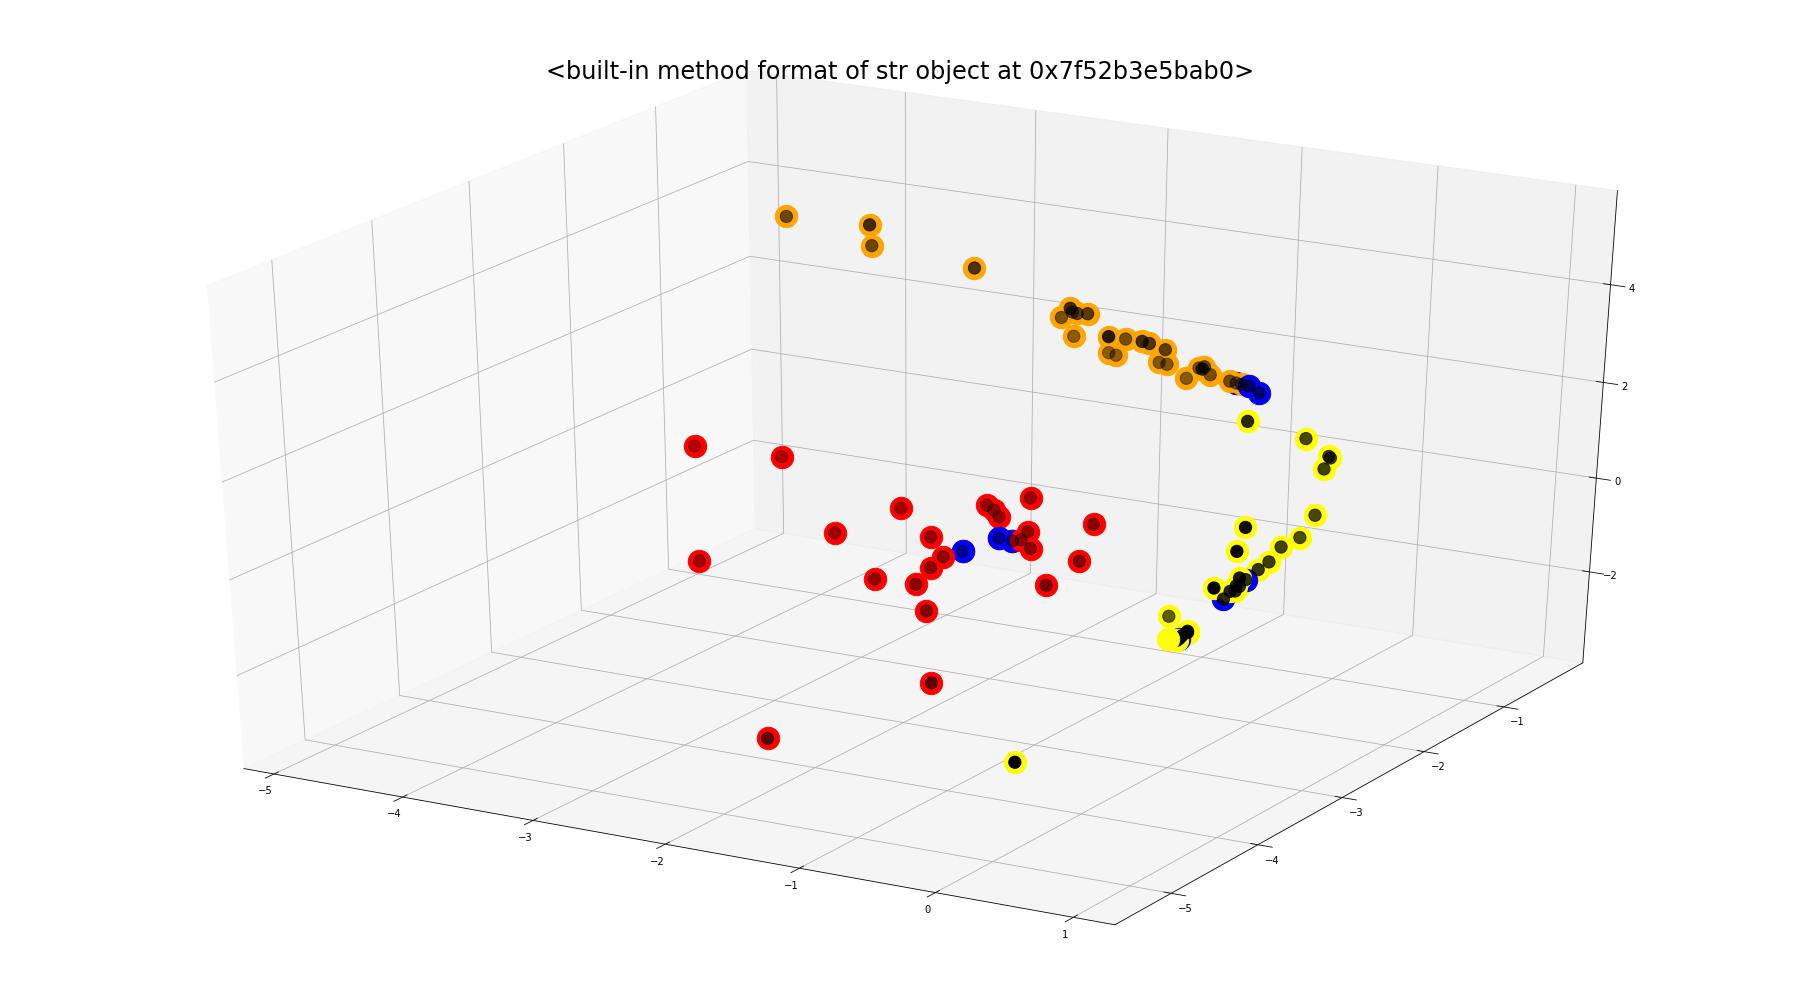

In [94]:
# Experiment on the strong group connection graph; by changing the hyperparameter p, q
representation_create_and_plot(graph75, p=1, q=4) # with setting p=1, q=4

Elapsed time: 66.8991s
Nodes that has similar representaion to 'Central Node 12'
[('10', 0.9998392462730408), ('17', 0.9996504187583923), ('27', 0.9985735416412354), ('18', 0.9985108971595764), ('2', 0.9982848167419434), ('13', 0.9943652749061584), ('8', 0.9940197467803955), ('24', 0.9932661056518555), ('9', 0.9796138405799866), ('20', 0.9788958430290222)]
Nodes that has similar representaion to 'Central Node 13'
[('18', 0.9984990358352661), ('27', 0.9970130324363708), ('17', 0.9966180324554443), ('9', 0.9953711628913879), ('20', 0.9950438737869263), ('10', 0.9948824048042297), ('4', 0.9947360157966614), ('12', 0.9943652749061584), ('14', 0.9940701723098755), ('15', 0.9934069514274597)]
Nodes that has similar representaion to 'Central Node 14'
[('20', 0.9998916983604431), ('15', 0.9998418092727661), ('9', 0.9997146129608154), ('4', 0.9997091889381409), ('6', 0.9988740086555481), ('13', 0.9940701127052307), ('19', 0.9873930811882019), ('18', 0.9866731762886047), ('27', 0.984226882457733

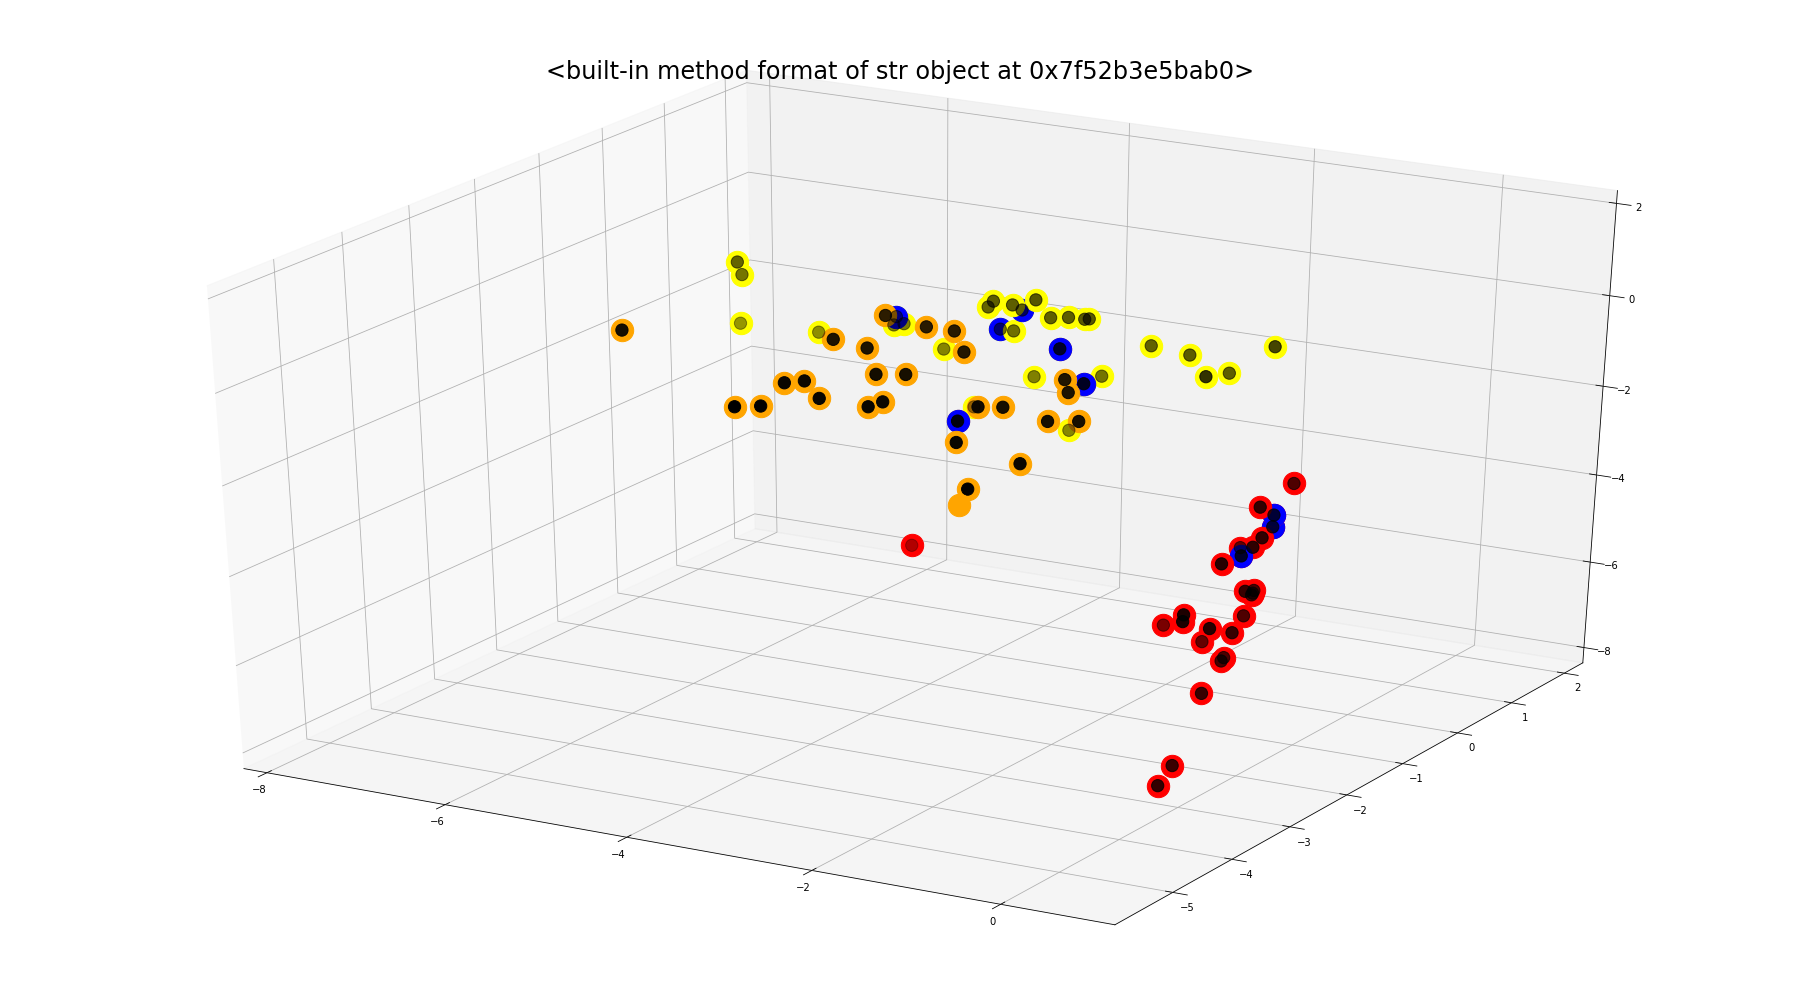

In [95]:
# to check the effect of the hyperparameters; same setting with above except p decreased(p = 1 -> p = 0.25)
representation_create_and_plot(graph75, p=0.25, q=4) # with setting p=0.25, q=4

Elapsed time: 66.5585s
Nodes that has similar representaion to 'Central Node 12'
[('10', 0.9992374181747437), ('22', 0.9989742040634155), ('6', 0.9984310865402222), ('8', 0.9971874356269836), ('18', 0.997172474861145), ('13', 0.9962660670280457), ('20', 0.9961854219436646), ('17', 0.9934383630752563), ('27', 0.9895324110984802), ('14', 0.9861360788345337)]
Nodes that has similar representaion to 'Central Node 13'
[('20', 0.9999721050262451), ('6', 0.9995368719100952), ('27', 0.9979972243309021), ('12', 0.9962660074234009), ('9', 0.9939666390419006), ('22', 0.9927636981010437), ('10', 0.9925092458724976), ('15', 0.9909485578536987), ('8', 0.9872004389762878), ('18', 0.9872000813484192)]
Nodes that has similar representaion to 'Central Node 14'
[('17', 0.9986028075218201), ('11', 0.9977065920829773), ('8', 0.9957530498504639), ('18', 0.9957491159439087), ('1', 0.9921753406524658), ('10', 0.9915581345558167), ('5', 0.9913755059242249), ('19', 0.990642786026001), ('22', 0.9888573884963989)

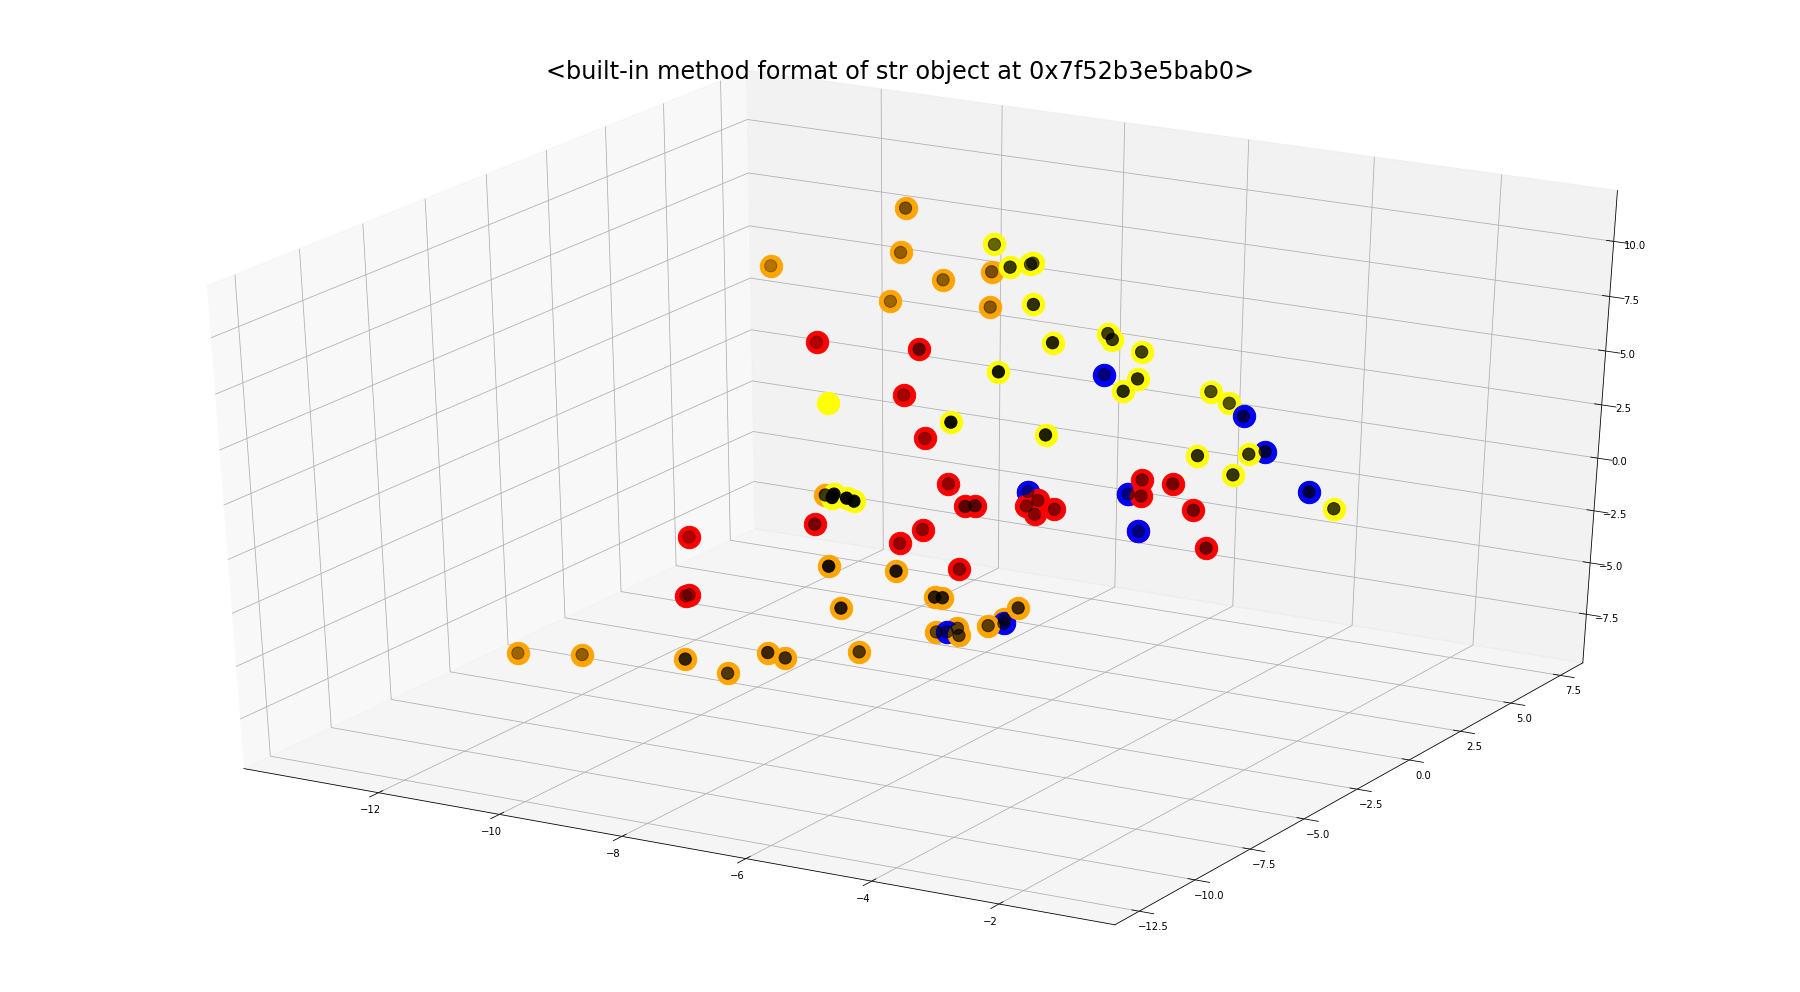

In [96]:
# to check the effect of the hyperparameters; same setting with above except p decreased, q increased (p=0.25 -> p=0.05, q=4->q=20)
representation_create_and_plot(graph75, p=0.05, q=20) # with setting p=0.05, q=20

Elapsed time: 64.1981s
Nodes that has similar representaion to 'Central Node 12'
[('4', 0.999960720539093), ('14', 0.9996078610420227), ('25', 0.999517023563385), ('2', 0.997778058052063), ('24', 0.9968224763870239), ('27', 0.9965253472328186), ('19', 0.9928276538848877), ('20', 0.986413836479187), ('5', 0.9842713475227356), ('11', 0.9781473875045776)]
Nodes that has similar representaion to 'Central Node 13'
[('7', 0.9996235370635986), ('15', 0.999432384967804), ('26', 0.9989598989486694), ('8', 0.998228132724762), ('18', 0.997835636138916), ('16', 0.997698187828064), ('1', 0.996404767036438), ('17', 0.996309220790863), ('10', 0.9928374290466309), ('6', 0.9917134642601013)]
Nodes that has similar representaion to 'Central Node 14'
[('12', 0.9996078610420227), ('4', 0.9994456171989441), ('25', 0.9991791248321533), ('2', 0.9975351095199585), ('27', 0.9965282082557678), ('24', 0.9964196681976318), ('19', 0.9947618246078491), ('20', 0.9881672263145447), ('5', 0.9816148281097412), ('11', 0

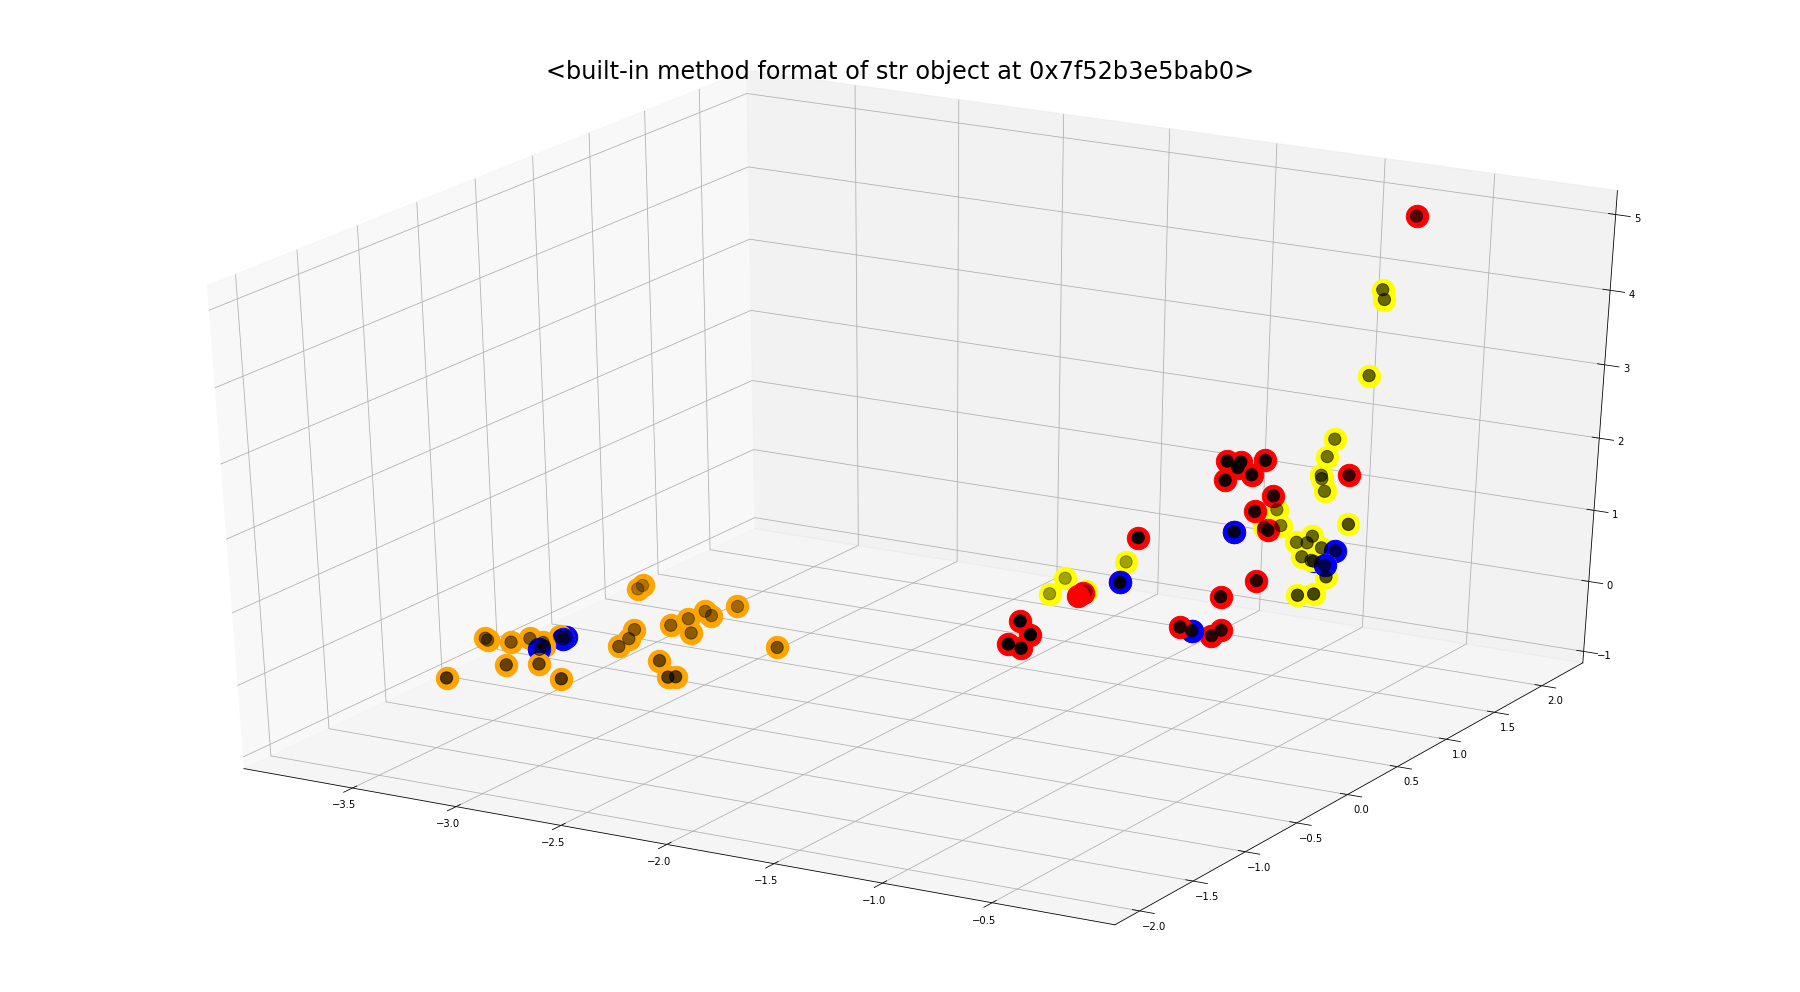

In [97]:
# to check the effect of the hyperparameters; same setting with above except p increased, q decreased (p=0.05 -> p=4, q=20->q=1)
representation_create_and_plot(graph75, p=4, q=1) # with setting p=4, q=1

Elapsed time: 62.7709s
Nodes that has similar representaion to 'Central Node 12'
[('27', 0.9984273314476013), ('11', 0.9960817098617554), ('5', 0.9932513236999512), ('22', 0.9886640906333923), ('29', 0.9877641797065735), ('14', 0.9856125116348267), ('8', 0.9746502637863159), ('17', 0.9743951559066772), ('9', 0.972661554813385), ('15', 0.9717616438865662)]
Nodes that has similar representaion to 'Central Node 13'
[('4', 0.9993955492973328), ('6', 0.9993951916694641), ('24', 0.9972407221794128), ('2', 0.9966254830360413), ('19', 0.996412456035614), ('1', 0.9962314367294312), ('7', 0.9954328536987305), ('10', 0.9951452612876892), ('25', 0.9927462339401245), ('18', 0.9917442798614502)]
Nodes that has similar representaion to 'Central Node 14'
[('8', 0.9984306693077087), ('17', 0.9983670115470886), ('9', 0.9978744983673096), ('15', 0.9976544976234436), ('20', 0.9974050521850586), ('18', 0.9959399700164795), ('25', 0.995181679725647), ('27', 0.993466854095459), ('10', 0.9924902319908142), ('

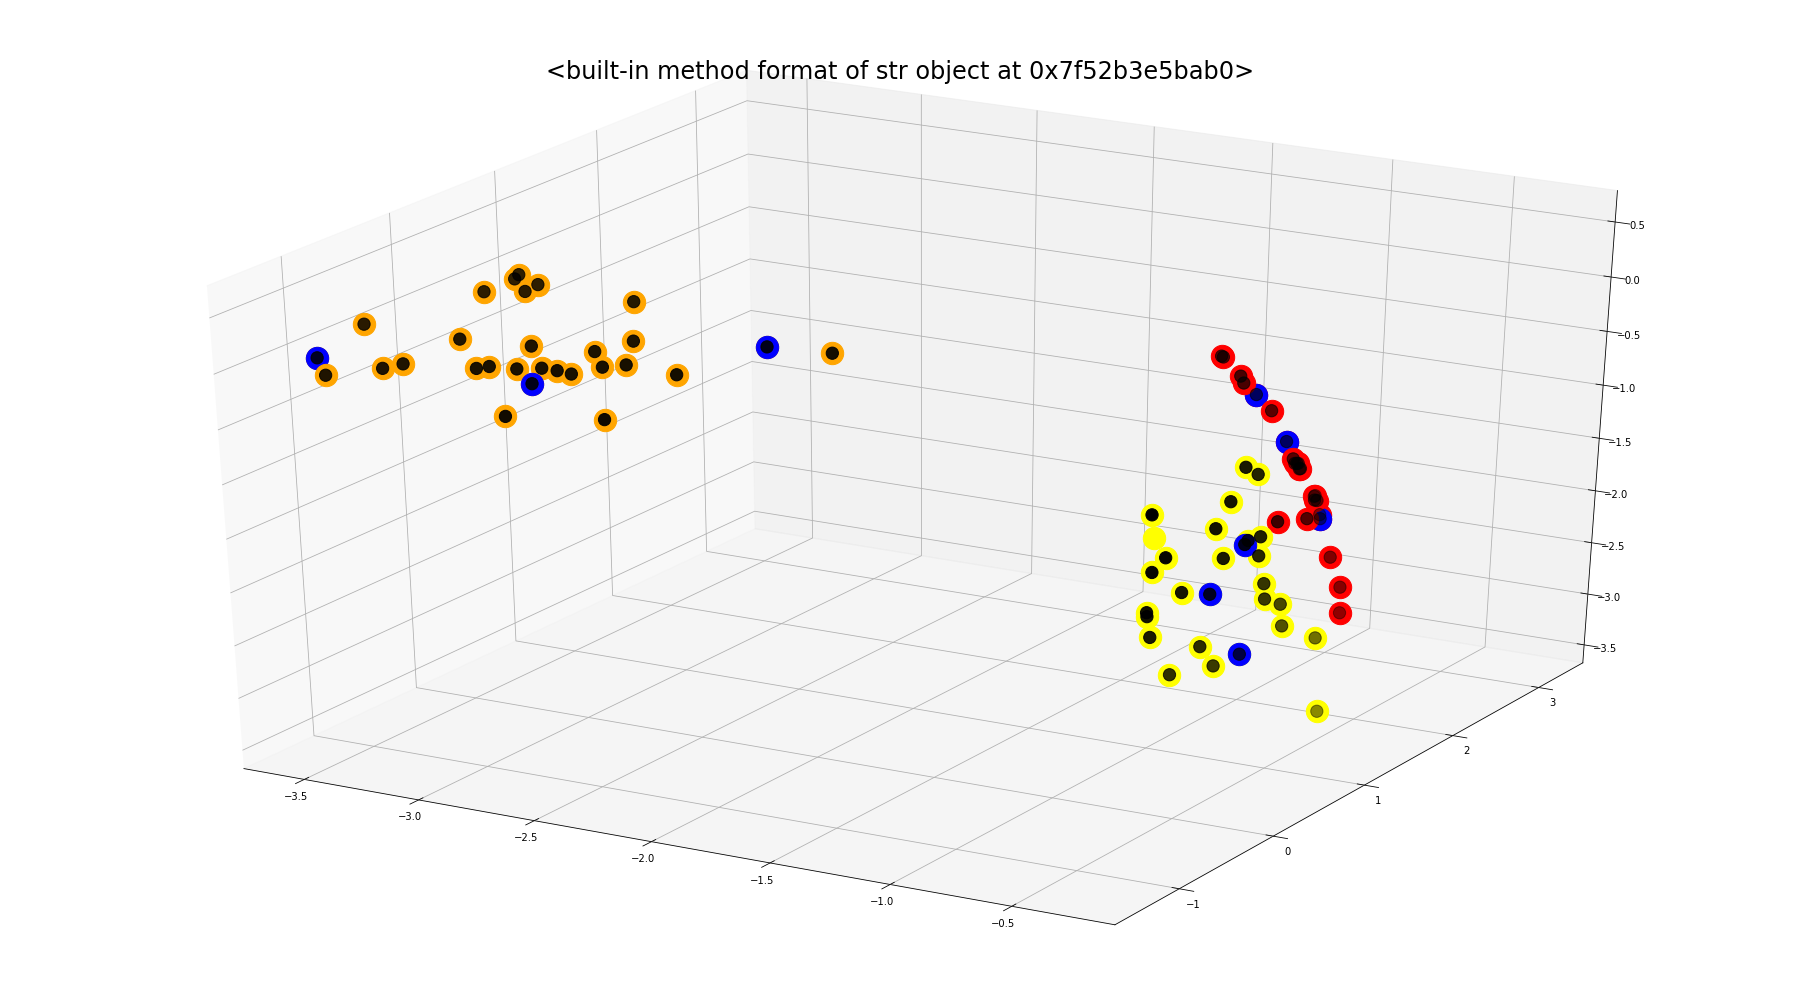

In [98]:
# to check the effect of the hyperparameters; same setting with above except q decreased (q=1->q=0.25)
representation_create_and_plot(graph75, p=4, q=0.25) # with setting p=4, q=0.25

Elapsed time: 62.5493s
Nodes that has similar representaion to 'Central Node 12'
[('6', 0.9999645352363586), ('17', 0.9981915950775146), ('8', 0.997698187828064), ('20', 0.9976698756217957), ('13', 0.9976577162742615), ('24', 0.9974362850189209), ('15', 0.9962944388389587), ('16', 0.9938586950302124), ('10', 0.9877181053161621), ('27', 0.9871757626533508)]
Nodes that has similar representaion to 'Central Node 13'
[('15', 0.9998430013656616), ('24', 0.999809205532074), ('16', 0.9991000890731812), ('6', 0.99808669090271), ('12', 0.9976575970649719), ('17', 0.9921964406967163), ('9', 0.991265594959259), ('20', 0.9910746216773987), ('8', 0.9909911155700684), ('18', 0.9897151589393616)]
Nodes that has similar representaion to 'Central Node 14'
[('11', 0.9998159408569336), ('2', 0.9996593594551086), ('7', 0.9993798136711121), ('18', 0.9990921020507812), ('19', 0.9982765316963196), ('9', 0.9974310994148254), ('3', 0.9960035681724548), ('16', 0.9917799830436707), ('56', 0.9886622428894043), ('

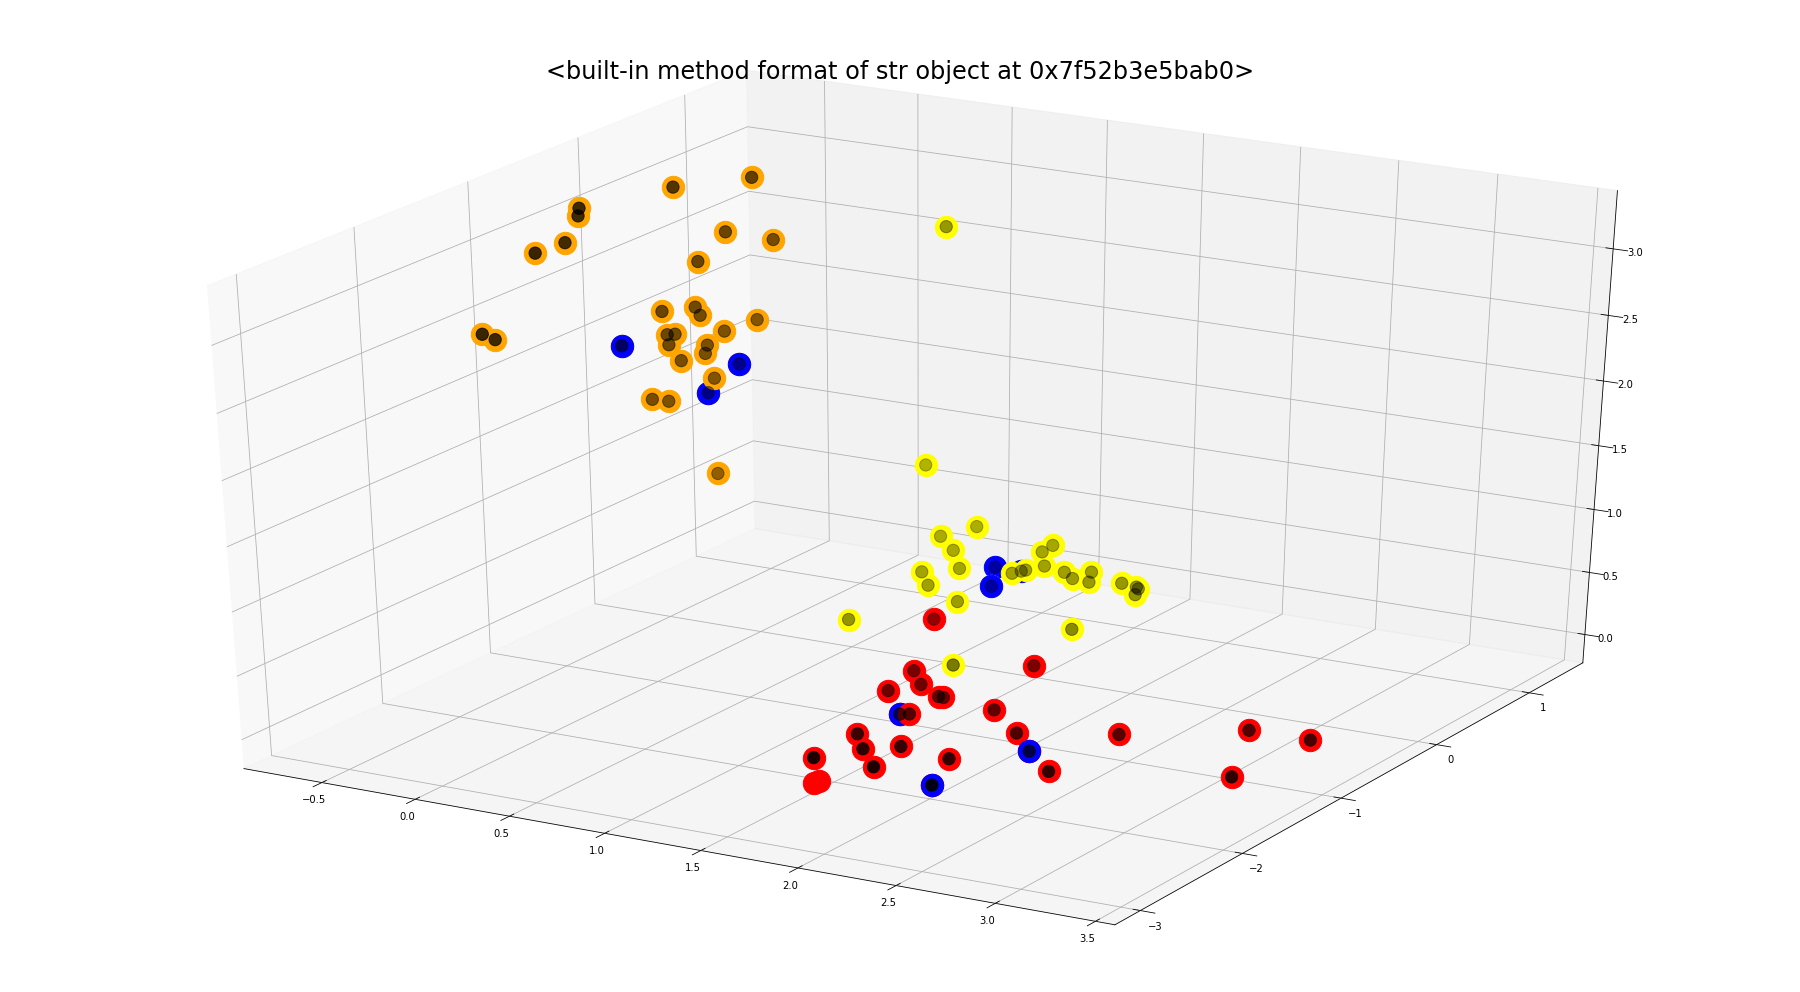

In [99]:
# to check the effect of the hyperparameters; same setting with above except p increased, q decreased (p=4 -> p=20, q=0.25->q=0.05)
representation_create_and_plot(graph75, p=20, q=0.05) # with setting p=20, q=0.05

### comments

Here, propose the algorithm that uses Hierarchical Softmax instead of Negative sampling

In [100]:
#### Node2Vec Algorithm####
# with modification(probability estimation method changed; Negative sampling -> Hierarchical softmax) 
## In here, I just modified my implementations of DeepWalk, especially on 'biased walk'

def Node2Vec_hs(G=None, w=10, d=3, gamma=30, t=40, p=1, q=1):
  '''
  <Input>
  Graph G (class networkx.Graph)

  <Hyperparameters>
  Window size w (int)
  Imbedding dimension d (int)
  Walks per vertex gamma (int)
  Walk length t (int)
  Return parameter p (float)
  In-Out parameter q (float)


  <Output>
  Imbedding X_embed (class numpy.ndarray)
  '''

  ############ defining function of making Biased Random Walks #################
  def BiasedRandWalk(G, N, t, p, q):
    '''
    <Input>
    Graph G (class networkx.Graph)
    root node N
    Walk length t (int)
    Return parameter p (float)
    In-Out parameter q (float)

    <Output>
    Walk walk (python list)
    '''
    rng = np.random.default_rng(42)

    walk = [str(N)] # defining walk
    prev = None # previous state
    curr = N # current state
    next = None # next state

    # Sampling the nodes t-1 times
    for i in range(t-1):
      nbhd =  list(G.neighbors(curr)) # get list of neighbors of the current node
      # if given current node is isolated, break the loop.
      if len(nbhd) < 0:
        break

      # at first sample draw
      if i==0:
        unnormdist = np.array([d["weight"] for (u, v, d) in G.edges(curr, data=True, default=1)])
        nbhd = [v for (u, v, d) in G.edges(curr, data=True, default=1)]
        normdist = unnormdist/np.sum(unnormdist)
        prev = curr # updating previous state
        next = rng.choice(nbhd, p=normdist) # updating next state
        curr = next # updating current state

      else:
        unnormdist = []
        nbhd = []
        for (u, v, d) in G.edges(curr, data=True, default=1):
          nbhd.append(v)
          if v in list(G.neighbors(prev)):
            trans_prob = d['weight']
          elif prev == v:
            trans_prob = d['weight']/p
          else:
            trans_prob = d['weight']/q
          unnormdist.append(trans_prob)
        unnormdist = np.array(unnormdist)
        normdist = unnormdist/np.sum(unnormdist)
        prev = curr # updating previous state
        next = rng.choice(nbhd, p=normdist) # updating next state
        curr = next # updating current state

      # recording
      walk.append(str(next))

    return walk
  ######################################################################
  rng = np.random.default_rng(42)
  NodeList = list(G.nodes())

  # Random Walk generating process
  walks = []
  for i in range(gamma):
    for node in NodeList:
      walk = BiasedRandWalk(G, node, t, p, q)
      walks.append(walk)
    rng.shuffle(NodeList) # shuffle the nodes

  # updating representation
  model = Word2Vec(sentences=walks, size=d, window=w, min_count=0, hs=1, sg=1, iter=100, batch_words=1, workers=4)

  return model.wv.vectors, model

In [101]:
def representation_create_and_plot_hs(my_Graph, p, q):
  import time
  ## creating representations of my_Graphs.
  t = time.time()
  ver_rep, model = Node2Vec_hs(G=my_Graph, d=3, p=p, q=q)
  print("Elapsed time: {:.4f}s".format(time.time()-t))

  # plot the results
  fig = plt.figure(figsize=(32,18))
  ax = fig.gca(projection='3d')
  x, y, z = ver_rep[:,0], ver_rep[:,1], ver_rep[:,2]
  ax.scatter(x,y,z, s=150, c='black')

  # checking homophily
  for i in range(30):
    node1, node2, node3 = i, i+30, i+60 # nodes in different clusters
    if node1 in list(my_Graph.nodes()):
      vec1 = model.wv[str(node1)]
      x1, y1, z1 = vec1[0], vec1[1], vec1[2]
      ax.scatter(x1,y1,z1, s=500, c='red')
    if node2 in list(my_Graph.nodes()):
      vec2 = model.wv[str(node2)]
      x2, y2, z2 = vec2[0], vec2[1], vec2[2]
      ax.scatter(x2,y2,z2, s=500, c='yellow')
    if node3 in list(my_Graph.nodes()):
      vec3 = model.wv[str(node3)]
      x3, y3, z3 = vec3[0], vec3[1], vec3[2]
      ax.scatter(x3,y3,z3, s=500, c='orange')

  # checking Structural equivalence
  for i in [12, 13, 14, 42, 43, 44, 72, 73, 74]:
    if i in list(my_Graph.nodes()):
      vec = model.wv[str(i)]
      x, y, z = vec[0], vec[1], vec[2]
      ax.scatter(x,y,z, s=500, c='blue')

  # Also checking Homophily and Structural Equivalence by looking at similar vectors obtained by cosine similarity
  for i in [12, 13, 14, 42, 43, 44, 72, 73, 74]:
    if i in list(my_Graph.nodes()):
      print("Nodes that has similar representaion to 'Central Node {}'".format(i))
      print("({}, {})".format(node, sim) for (node, sim) in list(model.wv.most_similar(str(i))))

  plt.title('representations for the graph <my_Graph>'.format, fontsize=24)
  plt.show()
  

     Go  To  weight
0     0   9       1
1     1   9       1
2     1  19       2
3     1  31       2
4     1  40       2
..   ..  ..     ...
315  87  88       1
316  88  73       1
317  88  77       2
318  89  74       2
319  89  76       1

[320 rows x 3 columns]


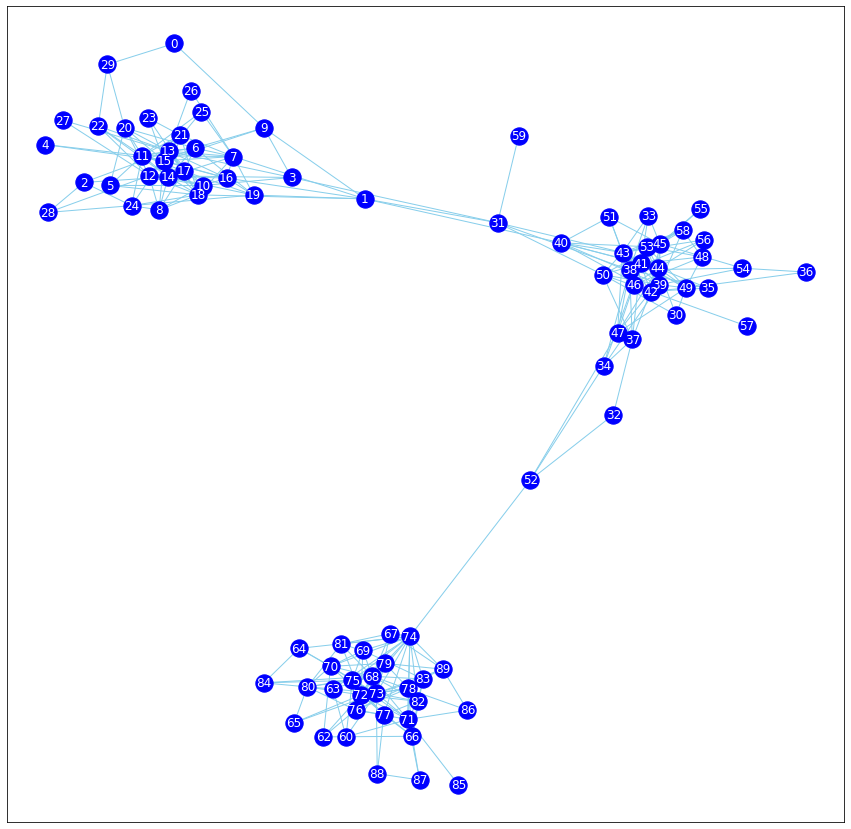

In [102]:
# Experiment on the strong group connection graph; by changing the hyperparameter p, q
graph150 = GraphGeneration(150)
graph_plot(graph150)

Elapsed time: 73.7724s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b02500d0>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b02500d0>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b02506d0>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b02506d0>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b02500d0>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b02500d0>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

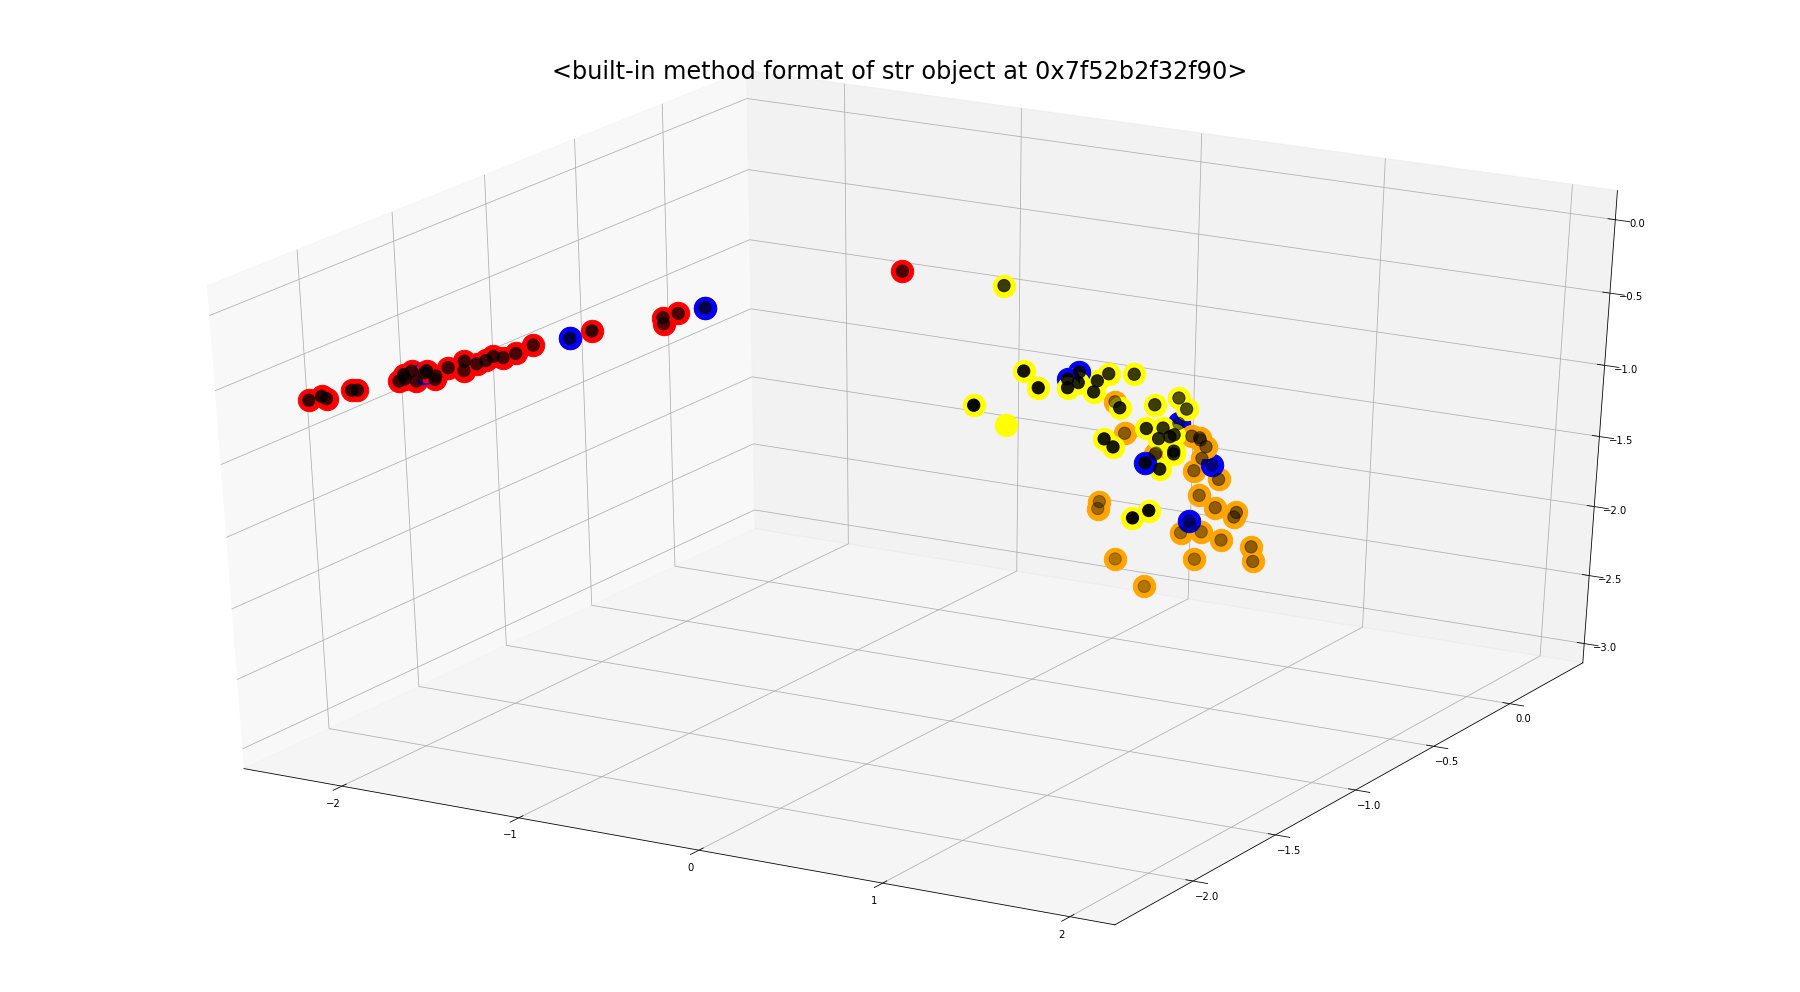

In [103]:
representation_create_and_plot_hs(graph150, p=1, q=0.25) # with setting p=1, q=0.25

Elapsed time: 70.8201s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0056050>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0056050>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0056150>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0056150>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0056050>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0056050>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

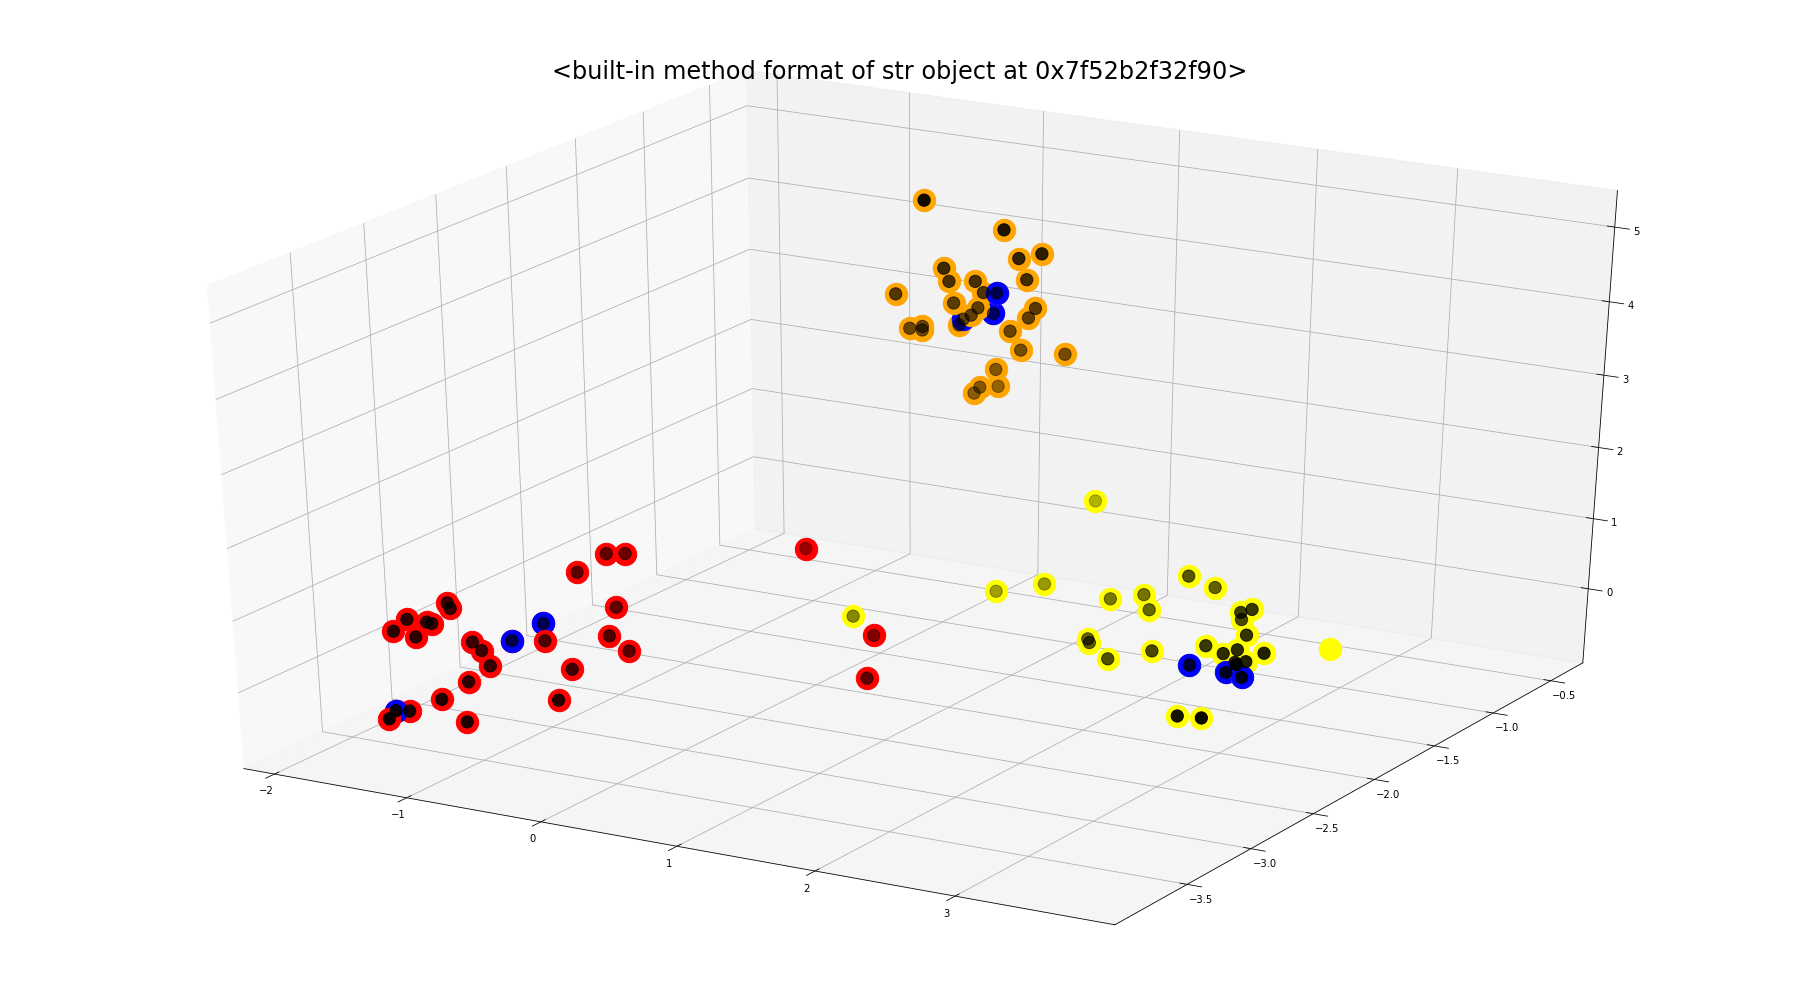

In [104]:
representation_create_and_plot_hs(graph150, p=1, q=4) # with setting p=1, q=4

Elapsed time: 72.1053s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0f8b150>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0f8b150>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0f8b050>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0f8b050>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0f8b050>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0f8b150>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

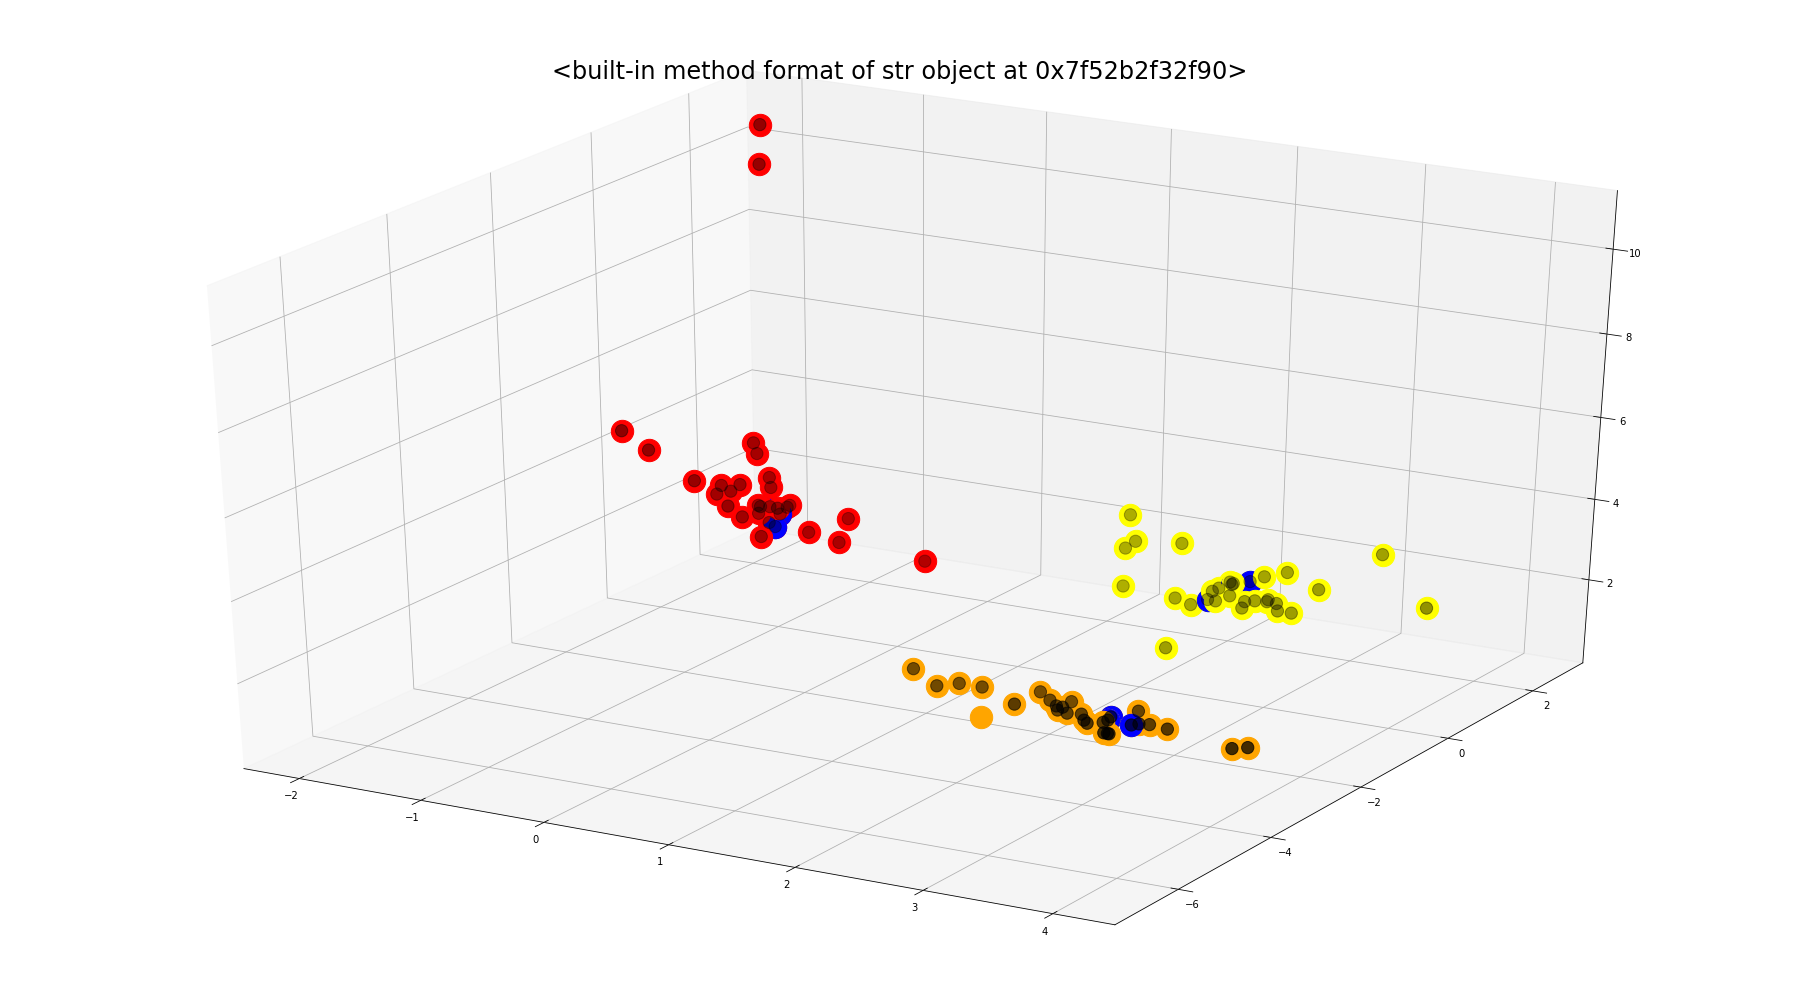

In [105]:
# to check the effect of the hyperparameters; same setting with above except p decreased(p = 1 -> p = 0.25)
representation_create_and_plot_hs(graph150, p=0.25, q=4) # with setting p=0.25, q=4

Elapsed time: 70.7039s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0104150>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0104150>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b01040d0>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b01040d0>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0104150>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b0104150>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

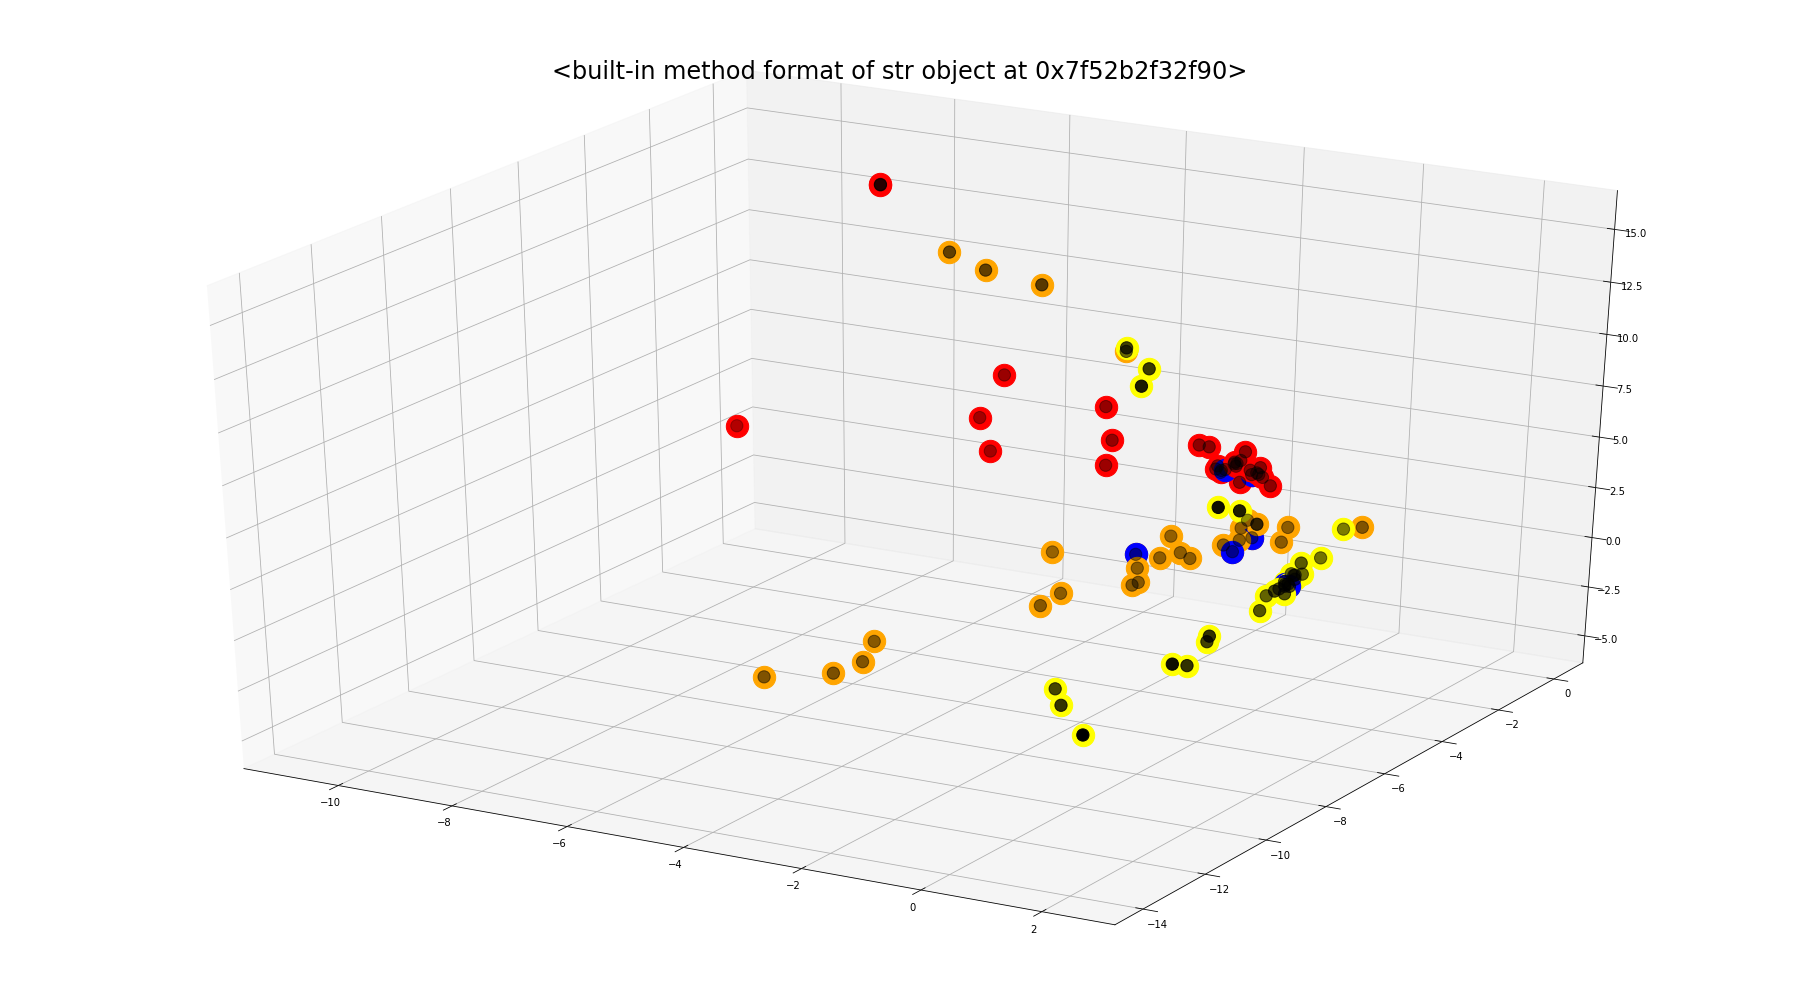

In [106]:
# to check the effect of the hyperparameters; same setting with above except p decreased, q increased (p=0.25 -> p=0.05, q=4->q=20)
representation_create_and_plot_hs(graph150, p=0.05, q=20) # with setting p=0.05, q=20

Elapsed time: 72.2140s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b000c150>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b000c150>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b000c150>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b000c050>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b000c050>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b000c150>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

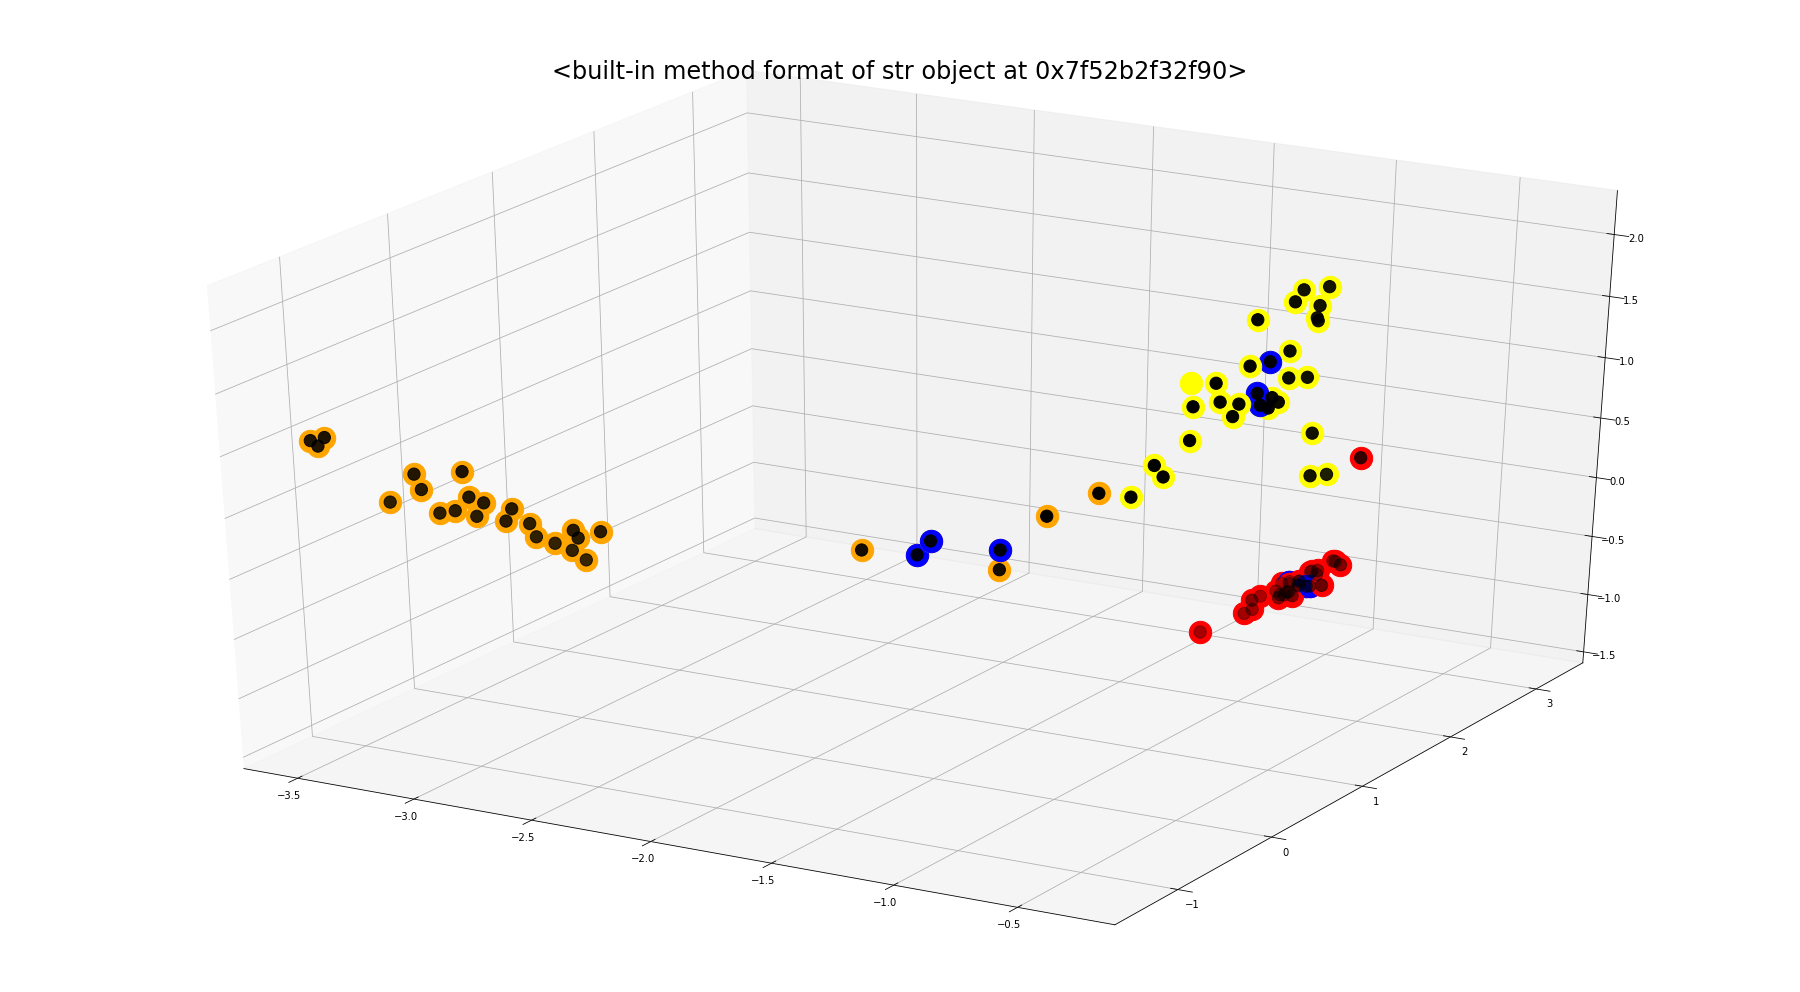

In [107]:
# to check the effect of the hyperparameters; same setting with above except p increased, q decreased (p=0.05 -> p=4, q=20->q=1)
representation_create_and_plot_hs(graph150, p=4, q=1) # with setting p=4, q=1

Elapsed time: 73.3400s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b12e3350>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b12e3350>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b12e3450>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b12e3450>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b12e3350>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b12e3350>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

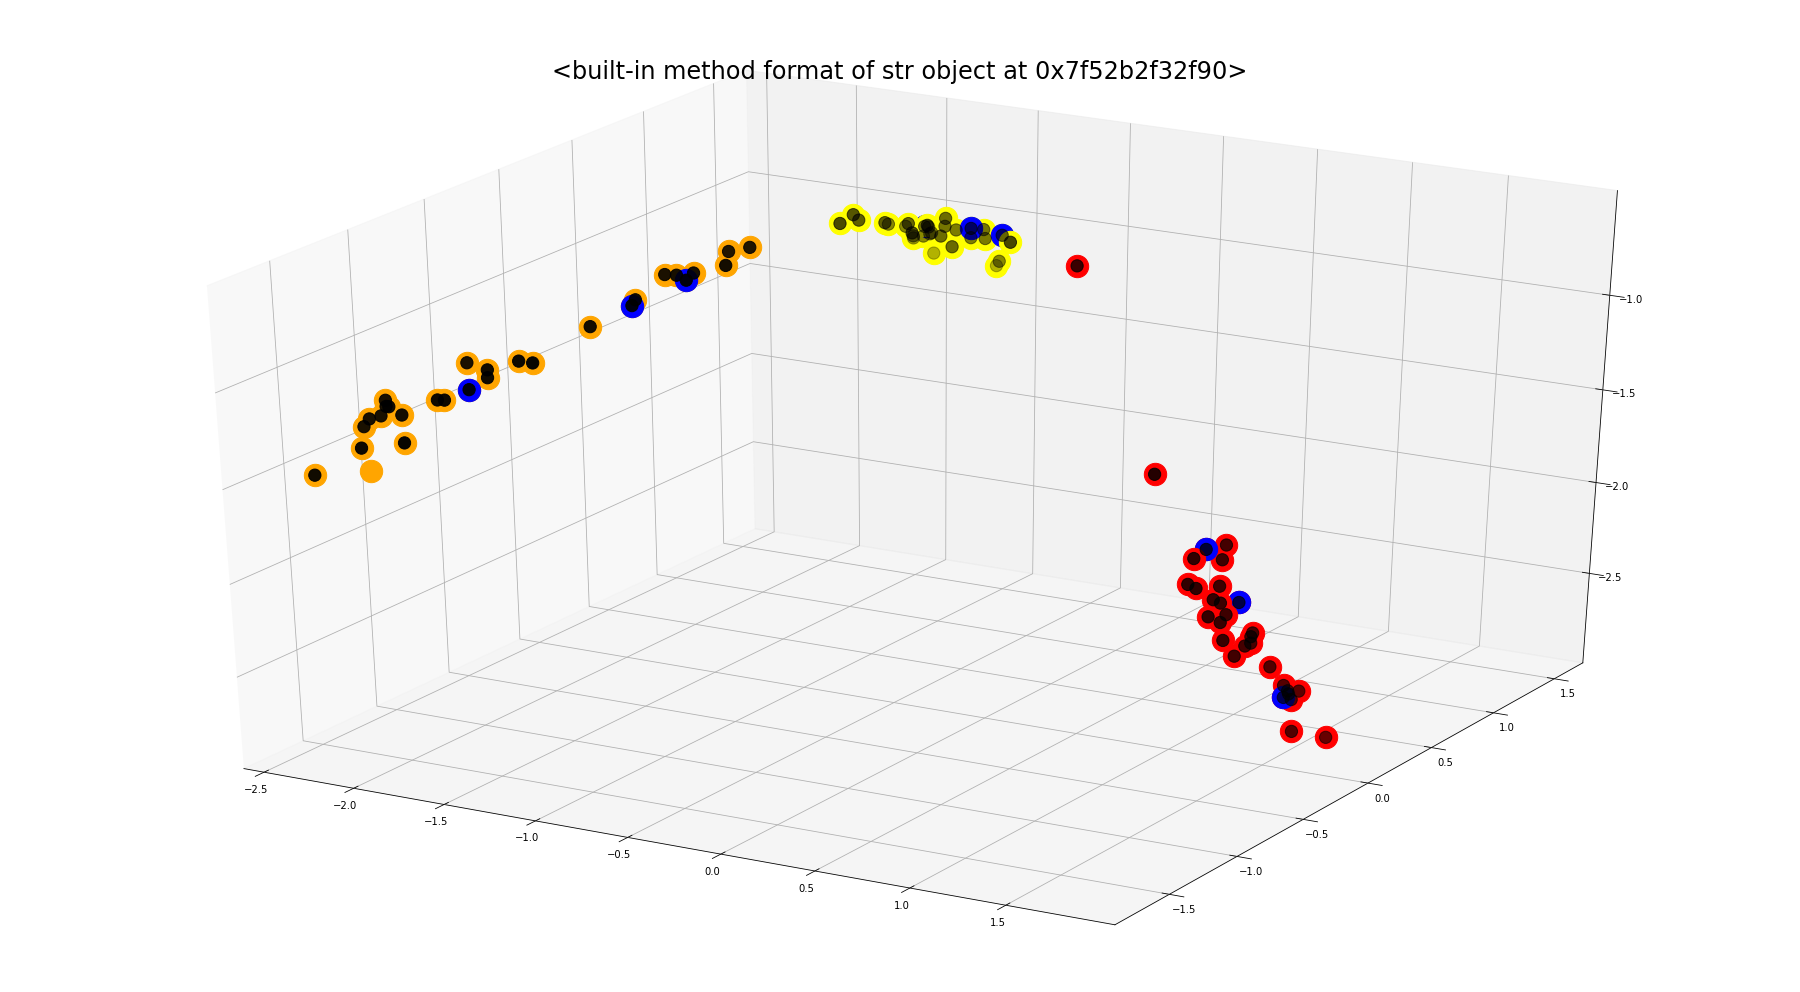

In [108]:
# to check the effect of the hyperparameters; same setting with above except q decreased (q=1->q=0.25)
representation_create_and_plot_hs(graph150, p=4, q=0.25) # with setting p=4, q=0.25

Elapsed time: 73.0244s
Nodes that has similar representaion to 'Central Node 12'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b33096d0>
Nodes that has similar representaion to 'Central Node 13'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b33096d0>
Nodes that has similar representaion to 'Central Node 14'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b3309450>
Nodes that has similar representaion to 'Central Node 42'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b3309450>
Nodes that has similar representaion to 'Central Node 43'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b33096d0>
Nodes that has similar representaion to 'Central Node 44'
<generator object representation_create_and_plot_hs.<locals>.<genexpr> at 0x7f52b33096d0>
Nodes that has similar representaion to 'Central Node 72'
<generator object representatio

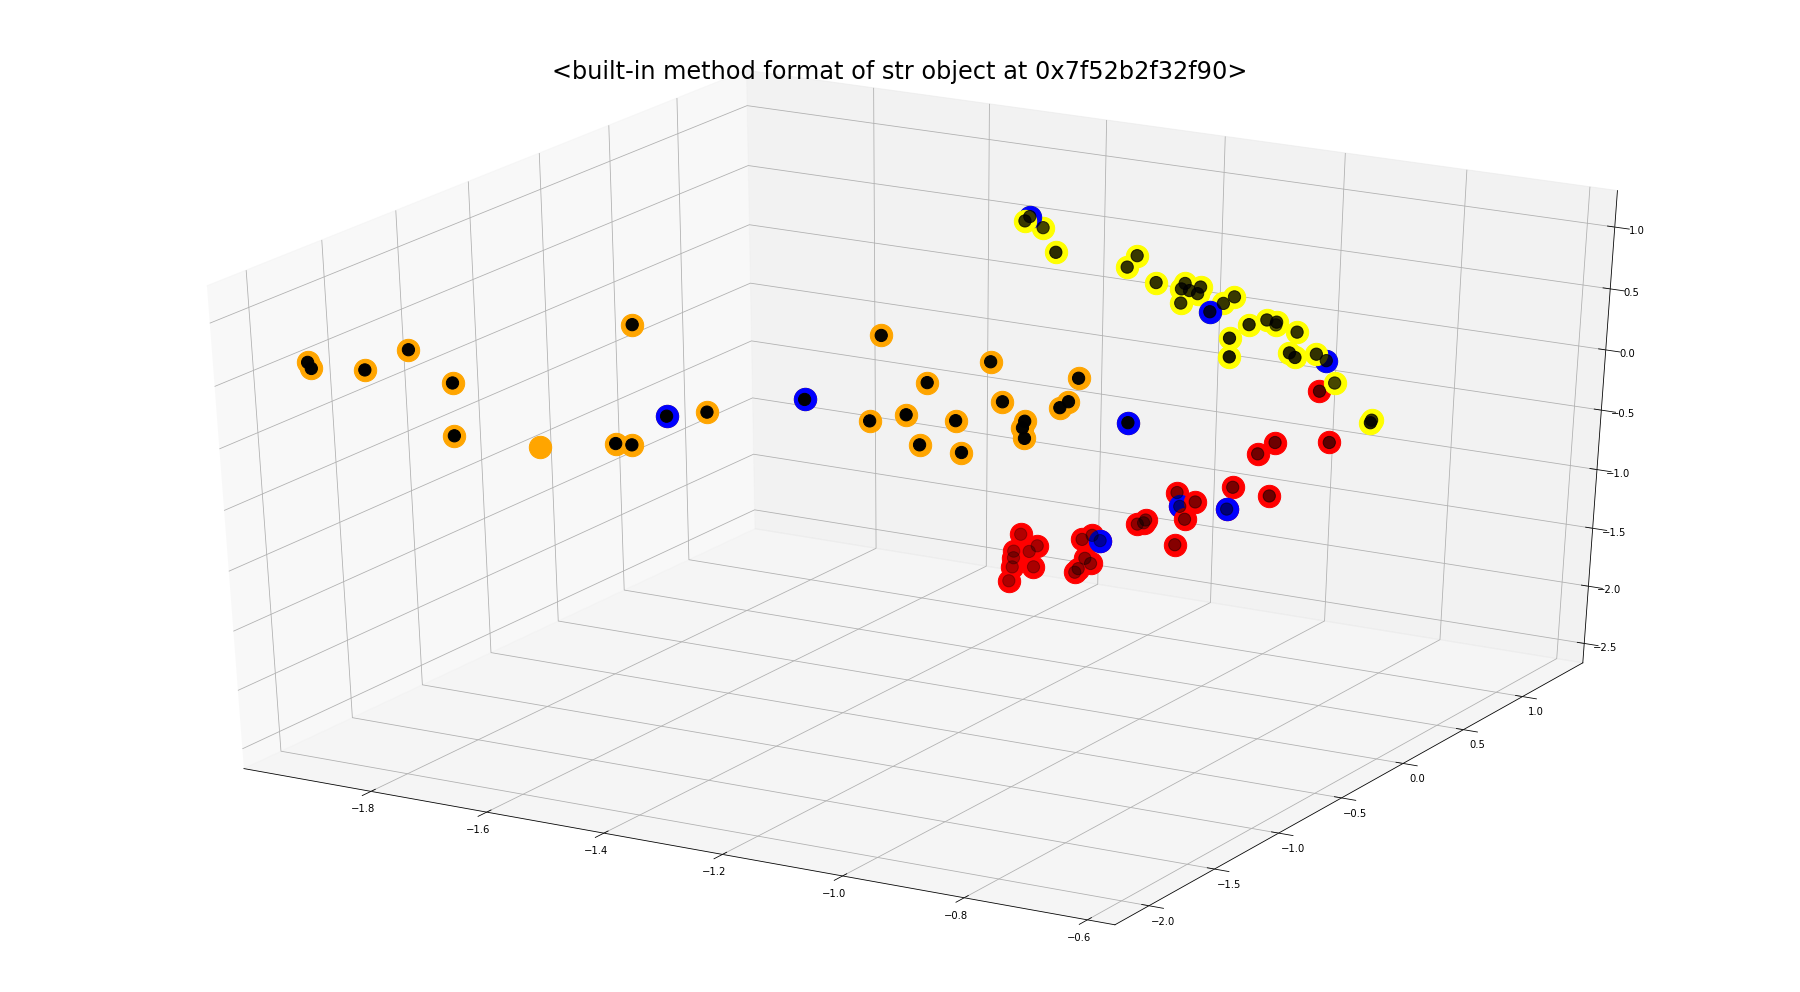

In [109]:
# to check the effect of the hyperparameters; same setting with above except p increased, q decreased (p=4 -> p=20, q=0.25->q=0.05)
representation_create_and_plot_hs(graph150, p=20, q=0.05) # with setting p=20, q=0.05

## Comments on the Experiments

By looking at the representations only, we can't check the effect of a/djusting the parameters. Maybe adding labels and executing classifications on it are more meaningful experiment for this.